<a href="https://colab.research.google.com/github/DollyWink/Colab_project/blob/main/COMP5625M__2023_YinghongChi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



<div class="logos"><img src="./Comp5625M_logo.jpg" width="220px" align="right"></div>


### Motivation

Through this assessment, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image-to-text model.
> 3. Use and compare two text similarity metrics for evaluating an image-to-text model, and understand evaluation challenges.


### Setup and resources

Having a GPU will speed up the image feature extraction process. If you want to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using PyTorch and Python-based libraries, and refer to the notebooks and exercises provided.

This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each with five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H).

``Info only:`` To understand more about the COCO dataset, you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)", but our image subset consists of fewer images than the original COCO dataset. **So, no need to download anything from here!**

> 2. **Image metadata**: as our set is a subset of the full COCO dataset, we have created a CSV file containing relevant metadata for our particular subset of images. You can also download it from Drive, "coco_subset_meta.csv", at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format. **Do not change the file name.**
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) are displayed in the .html for marking.

**Final note:**

> **Please include everything you would like to be marked in this notebook, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the appropriate section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):

### Imports

Feel free to add to this section as needed.

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from PIL import Image
from torch.utils.data import DataLoader

Detect which device (CPU/GPU) to use.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last convolutional layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects.

**(Hint)** You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you finetuned to COCO dataset.

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer* to speed up training. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use **RNN** in this assessment).

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) -->


<div>
<center><img src="comp5625M_figure_imageCaption.jpg" width="1000"/></center>
</div>


The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the **training more efficient by decoupling the networks**. Thus, we will:

> First extract the feature representations of the images from the Encoder

> Save these features (Part 1) such that during the training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

**Hint**
Try commenting out the feature extraction part once you have saved the embeddings. This way if you have to re-run the entire codes for some reason then you can only load these features.


### Overview

> 1. Extracting image features
> 2. Text preparation of training and validation data
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity


## 1 Extracting image features [11 marks]

> 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> 1.2 Image feature extraction step (7 marks)

#### 1.1 Design a encoder layer with pretrained ResNet50 (4 marks)

> Read through the template EncoderCNN class below and complete the class.

> You are expected to use ResNet50 pretrained on imageNet provided in the Pytorch library (torchvision.models)


In [ ]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]  # remove the last layer
        self.resnet = nn.Sequential(*modules)


    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():  # no gradients are needed
            features = self.resnet(images)
        return features.view(features.size(0), -1)


In [ ]:
# instantiate encoder and put into evaluation mode.
encoder = EncoderCNN()
encoder.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

#### 1.2 Image feature extraction step (7 marks)

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [ ]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [ ]:
# Get unique images from the csv for extracting features - helper code
imageList = pd.read_csv("/content/drive/MyDrive/coco_subset_meta.csv")
imageList['file_name']
len(imageList.id.unique())

imagesUnique = sorted(imageList['file_name'].unique())
print(len(imagesUnique))

df_unique_files =  pd.DataFrame.from_dict(imagesUnique)

df_unique_files.columns = ['file_name']
df_unique_files

5068


file_name
0     000000000009.jpg
1     000000000025.jpg
2     000000000030.jpg
3     000000000034.jpg
4     000000000036.jpg
...                ...
5063  000000581906.jpg
5064  000000581909.jpg
5065  000000581913.jpg
5066  000000581921.jpg
5067  000000581929.jpg

[5068 rows x 1 columns]

In [ ]:
# Define a class COCOImagesDataset(Dataset) function that takes the
# image file names and reads the image and apply transform to it
# ---> your code here! we have provided you a sketch

IMAGE_DIR = "/content/drive/MyDrive/images"

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        filename = self.df.iloc[index]['file_name']
        path = os.path.join(IMAGE_DIR, filename)
        image = Image.open(path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, filename

    def __len__(self):
        return len(self.df)


In [ ]:
# Use Dataloader to use the unique files using the class COCOImagesDataset
batch_size = 64
shuffle = False
dataset = COCOImagesDataset(df_unique_files, transform = data_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
features_map = dict()
from tqdm.notebook import tqdm
from PIL import Image

encoder = EncoderCNN()
with torch.no_grad():
# ---> Your code here!

    for images, filenames in tqdm(dataloader):
        # extract features from the images using the encoder
        features = encoder(images)

        # save the features and filenames to the features map
        for feature, filename in zip(features, filenames):
            image_id = int(filename.split('.')[0])
            features_map[image_id] = feature
            # features_map[filename] = feature

# save the features to a file using torch.save
torch.save(features_map, '/content/drive/MyDrive/features.pt')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/80 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## 2 Text preparation [23 marks]

> 2.1 Build the caption dataset (3 Marks)

> 2.2 Clean the captions (3 marks)

> 2.3 Split the data (3 marks)

> 2.4 Building the vocabulary (10 marks)

> 2.5 Prepare dataset using dataloader (4 marks)


#### 2.1 Build the caption dataset (3 Marks)

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="caption_image_ids.png" alt="images matched to caption" width="700"/>

In [ ]:
import json

# loading captions for training
with open('/content/drive/MyDrive/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)
df = pd.DataFrame.from_dict(data["annotations"])
df = df.sort_values(by='image_id')
df.rename(columns={'id': 'caption_id'}, inplace=True)
df.head()

image_id  caption_id  \
433247         9      661611   
433499         9      667602   
433454         9      666765   
433325         9      663627   
433263         9      661977   

                                                  caption  
433247  Closeup of bins of food that include broccoli ...  
433499         A bunch of trays that have different food.  
433454  Colorful dishes holding meat, vegetables, frui...  
433325  there are containers filled with different kin...  
433263  A meal is presented in brightly colored plasti...

In [ ]:
# Hint: get the filename matching id from coco_subset_meta.csv - make sure that for each id you add image filename
coco_subset = pd.read_csv("/content/drive/MyDrive/coco_subset_meta.csv")
coco_subset = coco_subset.sort_values(by='id')

In [ ]:
df_merged = coco_subset.merge(df, left_on="id", right_on="image_id")[["image_id", "caption_id", "caption","file_name"]]
new_file= df_merged.drop_duplicates().sort_values(by="image_id", ascending=True)
new_file= df_merged.drop_duplicates().sort_values(by="image_id", ascending=True)
new_file.rename(columns={'caption_id':'id' }, inplace=True)
new_file.head(10)

image_id      id                                            caption  \
0          9  661611  Closeup of bins of food that include broccoli ...   
1          9  667602         A bunch of trays that have different food.   
2          9  666765  Colorful dishes holding meat, vegetables, frui...   
3          9  663627  there are containers filled with different kin...   
4          9  661977  A meal is presented in brightly colored plasti...   
15        25  127076               A giraffe standing up nearby a tree    
16        25  127238      A giraffe mother with its baby in the forest.   
17        25  133058       Two giraffes standing in a tree filled area.   
18        25  133676  A giraffe standing next to a forest filled wit...   
19        25  122312    A giraffe eating food from the top of the tree.   

           file_name  
0   000000000009.jpg  
1   000000000009.jpg  
2   000000000009.jpg  
3   000000000009.jpg  
4   000000000009.jpg  
15  000000000025.jpg  
16  000000000025.jpg  
17  000000000025.jpg  
18  000000000025.jpg  
19  000000000025.jpg

#### 2.2 Clean the captions (3 marks)

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed.

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.


<img src="cleancaptions.png" alt="images matched to caption" width="700"/>

In [ ]:
new_file["clean_caption"] = "" # add a new column to the dataframe for the cleaned captions
import re
def gen_clean_captions_df(df):

    clean_captions = []

    for caption in df['caption']:

        # Remove spaces in the beginning and at the end
        clean_caption = caption.strip()

        # Convert to lower case
        clean_caption = clean_caption.lower()

        # Replace all non-alphabet characters with space
        clean_caption = re.sub(r'[^a-zA-Z]', ' ', clean_caption)

        # Replace all continuous spaces with a single space
        clean_caption = re.sub(r'\s+', ' ', clean_caption)

        clean_captions.append(clean_caption)

    # add to dataframe
    df["clean_caption"] = clean_captions

    return df

In [ ]:
# clean and print 10 of these
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

image_id      id                                            caption  \
0          9  661611  Closeup of bins of food that include broccoli ...   
1          9  667602         A bunch of trays that have different food.   
2          9  666765  Colorful dishes holding meat, vegetables, frui...   
3          9  663627  there are containers filled with different kin...   
4          9  661977  A meal is presented in brightly colored plasti...   
15        25  127076               A giraffe standing up nearby a tree    
16        25  127238      A giraffe mother with its baby in the forest.   
17        25  133058       Two giraffes standing in a tree filled area.   
18        25  133676  A giraffe standing next to a forest filled wit...   
19        25  122312    A giraffe eating food from the top of the tree.   

           file_name                                      clean_caption  
0   000000000009.jpg  closeup of bins of food that include broccoli ...  
1   000000000009.jpg         a bunch of trays that have different food   
2   000000000009.jpg  colorful dishes holding meat vegetables fruit ...  
3   000000000009.jpg  there are containers filled with different kin...  
4   000000000009.jpg  a meal is presented in brightly colored plasti...  
15  000000000025.jpg                a giraffe standing up nearby a tree  
16  000000000025.jpg      a giraffe mother with its baby in the forest   
17  000000000025.jpg       two giraffes standing in a tree filled area   
18  000000000025.jpg  a giraffe standing next to a forest filled wit...  
19  000000000025.jpg    a giraffe eating food from the top of the tree

#### 2.3  Split the data (3 marks)

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [ ]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)

    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)

    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [ ]:
image_ids = new_file['image_id'].unique().tolist()

random.shuffle(image_ids)

train_ids, val_ids, test_ids = split_ids(image_ids)

train_file = new_file[new_file['image_id'].isin(train_ids)].reset_index(drop=True)
val_file = new_file[new_file['image_id'].isin(val_ids)].reset_index(drop=True)
test_file = new_file[new_file['image_id'].isin(test_ids)].reset_index(drop=True)


#### 2.4 Building the vocabulary (10 marks)

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [ ]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [ ]:
# [Hint] building a vocab function such with frequent words e.g., setting MIN_FREQUENCY = 3
MIN_FREQUENCY = 3

def build_vocab(df_ids, new_file):
    """
    Parses training set token file captions and builds a Vocabulary object and dataframe for
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    # for index in df.index:
    for index, id in enumerate(df_ids):
        caption = str(new_file.loc[new_file['image_id']==id]['clean_caption'])
        for word in caption.split():
            # also get rid of numbers, symbols etc.
            if word in word_mapping:
                word_mapping[word] += 1

            else:
                word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word in word_mapping:
        # Ignore infrequent words to reduce the embedding size
        # --> Your code here!
        for word,count in word_mapping.items():
          if word_mapping[word] > MIN_FREQUENCY:
            vocab.add_word(word)

    return vocab


In [ ]:
vocab = build_vocab(np.concatenate((train_ids, val_ids),axis = 0),new_file)

#### 2.5 Prepare dataset using dataloader (4 marks)

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 2048).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [ ]:
MAX_SEQ_LEN = 47

class COCO_Features(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """

    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper

        """
        self.df = df
        self.features = features
        self.vocab = vocab
        self.max_seq_len = MAX_SEQ_LEN
        # TO COMPLETE

    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """
        row = self.df.iloc[index]
        img_id = row['image_id']
        try:
          feature = torch.tensor(self.features[img_id]).unsqueeze(0)
        except KeyError:
          feature = torch.zeros((1, 2048))

        caption = str(row['clean_caption'])
        caption_words = caption.split()

        caption_ids = [self.vocab(word) for word in caption_words]
        caption_ids.append(self.vocab('<end>'))

        caption_len = len(caption_ids)

        if caption_len > self.max_seq_len:
            caption_ids = caption_ids[:self.max_seq_len]
            caption_len = self.max_seq_len
        else:
            caption_ids += [self.vocab('<pad>')] * (self.max_seq_len - caption_len)

        caption_ids = torch.tensor(caption_ids)

        return feature, caption_ids, caption_len
       # TO COMPLETE
    def __len__(self):
        return len(self.df)


In [ ]:
from torch.nn.modules import padding
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption).
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort data by caption length from longest to shortest.
    data.sort(key=lambda x: len(x[1]), reverse=True)
    # Separate images and captions from data.
    images, captions, lengths = zip(*data)
    images = torch.stack(images)
    lengths = torch.tensor(lengths)
    targets = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True,padding_value=0)
    # Return the batch of images, padded captions, and the lengths of the original captions.
    return images, targets, lengths

In [ ]:
dataset_train = COCO_Features(
    df=train_file,
    vocab=vocab,
    features=features_map,
)
#  your dataloader here (make shuffle true as you will be training RNN)
# --> your code here!

train_loader = DataLoader(dataset=dataset_train, batch_size=64, shuffle=True, collate_fn=caption_collate_fn)

# Do the same as above for your validation set
# ---> your code here!
dataset_val = COCO_Features(
    df=val_file,
    vocab=vocab,
    features=features_map,
)
val_loader = DataLoader(dataset=dataset_val, batch_size=64, shuffle=False, collate_fn=caption_collate_fn)

Load one batch of the training set and print out the shape of each returned Tensor.

In [ ]:
images, targets, lengths = next(iter(train_loader))

# Print the shape of each Tensor
print(f"images shape: {images.shape}")
print(f"targets shape: {targets.shape}")
print(f"lengths shape: {lengths.shape}")

images shape: torch.Size([64, 1, 2048])
targets shape: torch.Size([64, 47])
lengths shape: torch.Size([64])


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


## 3 Train DecoderRNN [20 marks]

> 3.1 Design RNN-based decoder (10 marks)

> 3.2 Train your model with precomputed features (10 Marks)

#### 3.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```RNN``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last convolutional layer (flattened to dimensions after AdaptiveAvgPool2d that may give you => 1 x 1 x 2048, other layers are also accepted but this will affect your accuracy!)
        # into a Linear layer to resize
        self.resize = nn.Linear(2048, embed_size)

        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # your code for embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        # your code for RNN
        self.rnn = nn.RNN(input_size=embed_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        # self.linear: linear layer with input: hidden layer, output: vocab size
        self.linear = nn.Linear(hidden_size, vocab_size)

        self.max_seq_length = max_seq_length


    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)

        # compute your feature embeddings
        # your code
        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)

        # pack_padded_sequence returns a PackedSequence object, which contains two items:
        # the packed data (data cut off at its true length and flattened into one list), and
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data
        # [a, x, b, c] with batch_sizes=[2,1,1].

        # your code [hint: use pack_padded_sequence]
        packed = pack_padded_sequence(embeddings , lengths=lengths, batch_first=True,enforce_sorted=False)

        # Pass packed sequence through RNN
        hiddens, _ = self.rnn(packed)
        hint, _ = pad_packed_sequence(sequence=hiddens, batch_first=True, total_length=self.max_seq_length)

        outputs = self.linear(hint)
        return outputs

    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


In [ ]:
# instantiate decoder
# your code here!
decoder = DecoderRNN(vocab_size=len(vocab), embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47)


#### 3.2 Train your model with precomputed features (10 marks)

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [ ]:
# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(decoder.parameters(), lr=0.001)
#decoder = train_decoder.to(device)
# Train the decoder
num_epochs = 10
val_losses = []
train_losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    decoder.train() # set the model to train mode
    for i, (features, captions, lengths) in enumerate(train_loader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = decoder(features, captions, lengths)
        targets = pack_padded_sequence(captions, lengths, batch_first=True,enforce_sorted=False)[0]
        loss = criterion(outputs.view(-1, len(vocab)), targets)
        # Backward pass
        loss.backward()

        # Update the parameters
        optimizer.step()

        # Add the loss to the total training loss
        train_loss += loss.item()

    # Compute the average training loss
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # Display the training loss for this epoch
    print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss))
    # Evaluate the model on the validation set
    decoder.eval() # set the model to evaluation mode

    with torch.no_grad():
        for i, (features, captions, lengths) in enumerate(val_loader):
            # print(features,captions,lengths,"val")
            outputs = decoder(features, captions, lengths)
            targets = pack_padded_sequence(captions, lengths, batch_first=True,enforce_sorted=False)[0]
            loss = criterion(outputs.view(-1, len(vocab)), targets)
            # Add the loss to the total validation loss
            val_loss += loss.item()

    # Compute the average validation loss
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    # Display the validation loss for this epoch
    print('Epoch [{}/{}], Val Loss: {:.4f}'.format(epoch+1, num_epochs, val_loss))
    torch.save(decoder.state_dict(), "decoder_checkpoint.pth")
# Display a graph of training and validation loss over epochs to justify your stopping point

Epoch [1/10], Train Loss: 4.1878
Epoch [1/10], Val Loss: 3.4887
Epoch [2/10], Train Loss: 3.1669
Epoch [2/10], Val Loss: 3.1262
Epoch [3/10], Train Loss: 2.7984
Epoch [3/10], Val Loss: 2.9481
Epoch [4/10], Train Loss: 2.5515
Epoch [4/10], Val Loss: 2.8721
Epoch [5/10], Train Loss: 2.3547
Epoch [5/10], Val Loss: 2.8438
Epoch [6/10], Train Loss: 2.1799
Epoch [6/10], Val Loss: 2.8375
Epoch [7/10], Train Loss: 2.0136
Epoch [7/10], Val Loss: 2.8483
Epoch [8/10], Train Loss: 1.8568
Epoch [8/10], Val Loss: 2.8792
Epoch [9/10], Train Loss: 1.7080
Epoch [9/10], Val Loss: 2.9010
Epoch [10/10], Train Loss: 1.5642
Epoch [10/10], Val Loss: 2.9516


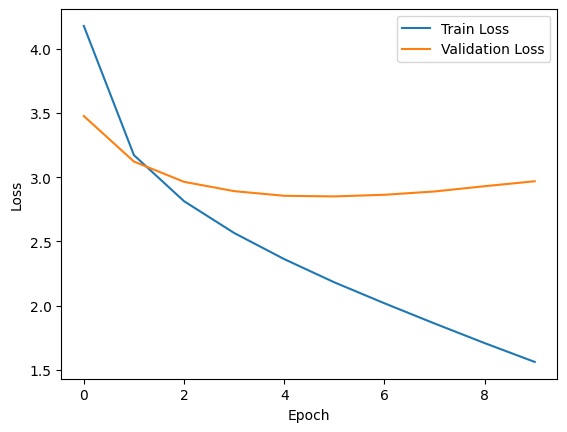

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

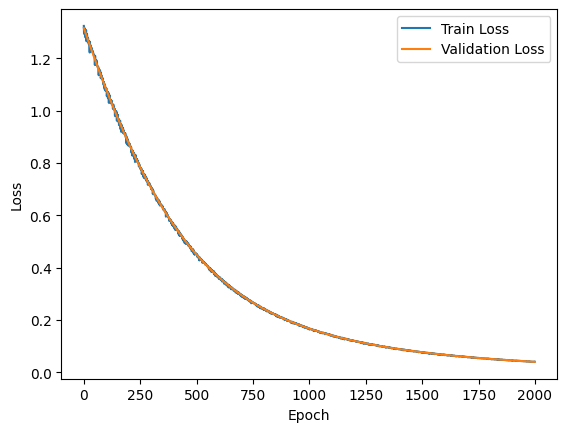

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## 4 Generate predictions on test data [8 marks]

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [ ]:
dataset_test = COCO_Features(
    df=test_file,
    vocab=vocab,
    features=features_map,
)
test_loader = DataLoader(dataset=dataset_test, batch_size=64, shuffle=False, collate_fn=caption_collate_fn)

In [ ]:
# decoder.load_state_dict(torch.load("/content/drive/MyDrive/decoder_checkpoint.pth"))
decoder.eval()
decoder = decoder.to(device)

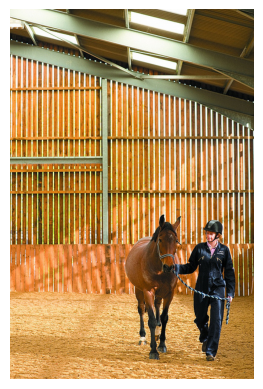

Generated caption: a person is riding a horse in a <unk>
Reference captions:
a woman walking a horse around a stable 
a horse that has a person next to it
someone leading a horse around an indoor arena
a rider walks beside a horse in an indoor area 
a woman leading a horse inside of a building 
--------------------------------------------------


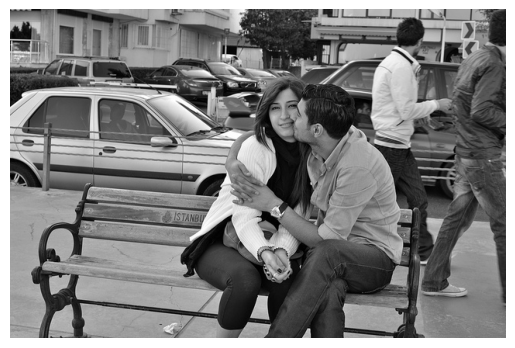

Generated caption: a man and a woman on a motorcycle
Reference captions:
black and white picture of guy and girl in an embrace on a park bench 
a man hugging a woman as they sit on a bench on the street with people walking behind them on the sidewalk 
a romantic couple smooching on a park bench traffic and pedestrians behind them 
a sitting on a bench and kissing woman on the check as people pass by 
a man kissing a woman while they sit on a bench on a sidewalk 
--------------------------------------------------


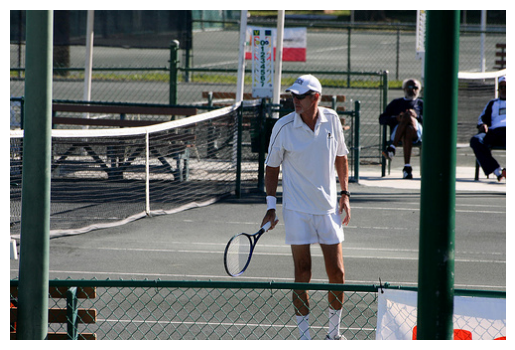

Generated caption: a man holding a tennis racquet on a tennis court
Reference captions:
a man in white playing tennis as others watch
a man standing on a tennis court holding a racquet 
a male tennis player with a hat and sunglasses standing on a hard surface court with a racket in his hand 
player on court during tennis match with onlookers nearby 
a man is playing tennis on a tennis court with people watching 
--------------------------------------------------


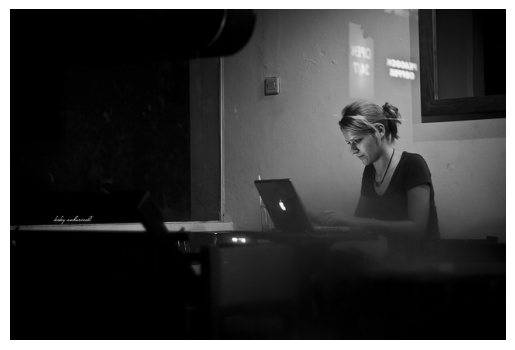

Generated caption: a man is standing in a kitchen with a sink
Reference captions:
a woman uses a laptop on a table top
a lady with a laptop working at a desk 
a woman sitting in front of a laptop computer 
a girl is using a laptop computer in a darkened room 
a woman sits alone working on a computer 
--------------------------------------------------


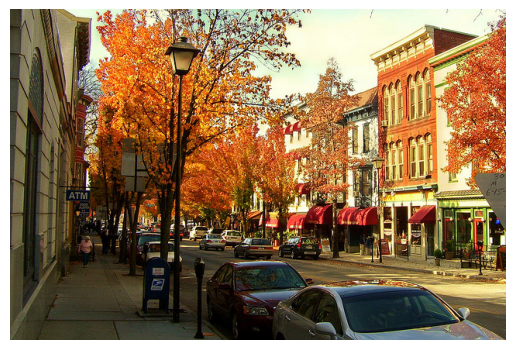

Generated caption: a <unk> is on a street next to a tree
Reference captions:
golden fall trees line the street of a lane of shops 
a sunny day in autumn with lots of orange trees 
the trees on the sidewalk all have orange leaves 
cars parked on a street during a sunny day 
the city is beautiful with the fall leaves in the trees 
--------------------------------------------------


In [ ]:
# Define function to decode captions
def decode_caption(caption, vocab):
    decoded_words = []
    for word_id in caption:
        word = vocab.idx2word[word_id.item()]
        if word == '<end>':
            break
        else:
            decoded_words.append(word)
    return ' '.join(decoded_words)

# Select 5 random test images
indices = np.random.choice(len(dataset_test), size=5, replace=False)

# Loop over images and display them along with generated and reference captions
for i in indices:
    # Get image and captions
    image, _, _ = dataset_test[i]
    reference_captions = test_file[test_file['image_id'] == dataset_test.df.iloc[i]['image_id']]['clean_caption']
    # Generate caption
    generated_caption = decoder.sample(image)
    generated_caption = generated_caption.flatten()  # Flatten the tensor
    generated_caption = decode_caption(generated_caption, vocab)
    # Display image and captions
    img = Image.open(IMAGE_DIR+"/"+test_file['file_name'].iloc[i])
    # /content/drive/MyDrive/images/000000000009.jpg
    plt.imshow(np.asarray(img))
    plt.axis('off')
    plt.show()
    print("Generated caption:", generated_caption)
    print("Reference captions:")
    for caption in reference_captions:
        print(caption)
    print("-" * 50)

## 5 Caption evaluation using BLEU score [10 marks]

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

> 5.1 Average BLEU score on all data (5 marks)

> 5.2 Examplaire high and low score BLEU score samples (5 marks, at least two)

####  5.1 Average BLEU score on all data (5 marks)


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions.

Display a histogram of the distribution of scores over the test set.

In [ ]:
def generate_caption(img_tensor,vocab):
  img = Image.open(IMAGE_DIR+"/"+img_tensor).convert('RGB')
  img_tensor = data_transform(img)
  feat = encoder(img_tensor.unsqueeze(0))
  sampled_indices = decoder.sample(feat)
  sampled_indices = sampled_indices.cpu().numpy()
  predicted_caption = []
  for token_index in sampled_indices:
    for index in token_index:
      word = vocab.idx2word[index]
      predicted_caption.append(word)
      if word == '<end>':
        break
  predicted_sentence = ' '.join(predicted_caption)
  print (predicted_sentence )
  return predicted_sentence

In [ ]:
def decode_caption(caption, vocab):
    decoded_words = []
    for word_id in caption:
        word = vocab.idx2word[word_id.item()]
        if word == '<end>':
            break
        else:
            decoded_words.append(word)
    return ' '.join(decoded_words)

In [ ]:
# --> Your code here!
from nltk.translate.bleu_score import sentence_bleu
stats = pd.DataFrame(columns=['ref','preds','bleu','cos_sim'])#dict()
import numpy as np
import matplotlib.pyplot as plt
bleu_scores = []
high = [0,0]
low = [0,1]
# Loop over images and display them along with generated and reference captions
all_indices = range(len(dataset_test))
for i in all_indices:
    # Get image and captions
    image, _, _ = dataset_test[i]
    image_id = test_file['file_name']
    reference_captions = test_file[test_file['image_id'] == dataset_test.df.iloc[i]['image_id']]['clean_caption']
    # Generate caption
    generated_caption = decoder.sample(image)
    generated_caption = generated_caption.flatten()  # Flatten the tensor
    generated_caption = decode_caption(generated_caption, vocab)
    reference_list = ' '.join(reference_captions).split('<end>')[0].strip().split(' ')
    reference_list = ' '.join(reference_captions)

# Calculate the BLEU score
    bleu_score = sentence_bleu(generated_caption,reference_list)
    print('blue_score: ',bleu_score)
    print('Generated caption:', generated_caption)
    print('Reference captions:', reference_captions)
    # Add the BLEU score to the list
    bleu_scores.append(bleu_score)
    temp = {'ref':caption, 'preds':reference_captions,'bleu':bleu_score, 'cos_sim':'' }
    stats=stats._append(temp, ignore_index=True)
    if bleu_score < low[1]:
      low = [i, bleu_score]
    if bleu_score > high[1]:
      high = [i, bleu_score]

Streaming output truncated to the last 5000 lines.
blue_score:  0.6894676483985203
Generated caption: a man is standing on a sidewalk at night
Reference captions: 35378    two parking meters that have been opened on a ...
35379          two parking meters with the tops opened up 
35380    two machines open while sitting on the side of...
35381      two parking meters are shown with the top open 
35382    two coin collection machines that are open on ...
Name: clean_caption, dtype: object
blue_score:  0.6894676483985203
Generated caption: a man is standing on a sidewalk at night
Reference captions: 35378    two parking meters that have been opened on a ...
35379          two parking meters with the tops opened up 
35380    two machines open while sitting on the side of...
35381      two parking meters are shown with the top open 
35382    two coin collection machines that are open on ...
Name: clean_caption, dtype: object
blue_score:  0.6894676483985203
Generated caption: a man is stand

Average BLEU score: 0.699985492608161


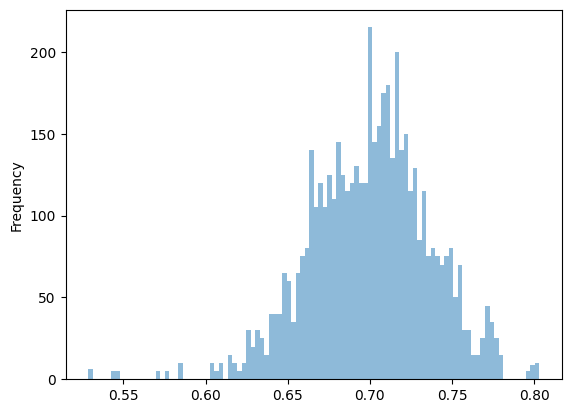

In [ ]:
print("Average BLEU score:", stats['bleu'].mean())
ax = stats['bleu'].plot.hist(bins=100, alpha=0.5)

#### 5.2 Examplaire high and low score BLEU score samples (5 marks)

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

Lowest BLEU score sample captions:
tensor([ 11,  51, 130,  71, 282, 116, 219,  19,  11,   1,   2,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0])
37359         a dog that is eating some food with a human 
37360            a dog takes a carrot stick from its owner
37361             a woman feeds a dog a mini carrot stick 
37362          a woman feeding a white dog a small carrot 
37358    a person gives their dog a baby carrot as a treat
Name: clean_caption, dtype: object
BLEU score: 0.0



Highest BLEU score sample captions:
tensor([ 95, 349,  49, 225,  90,  96, 391,  11, 545, 235,   2,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0])
6566    two zebras standing beside each othe

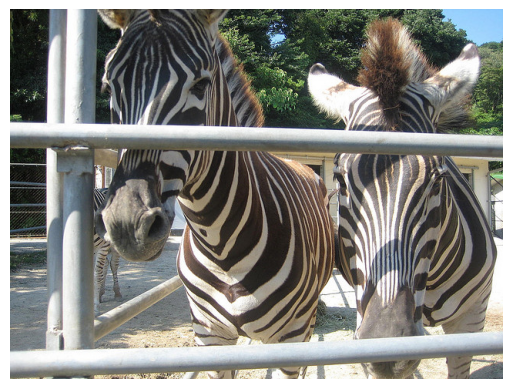

Generated caption:
two zebras that are standing in the grass
Reference captions:
two zebras standing beside each other behind a metal fence 
some very cute zebras standing by a fence 
two zebras that are standing in the dirt 
two zebras close to the fence looking at the person on the other side
a couple of zebra standing by a metal fence 
--------------------------------------------------
highest score: 0.840896


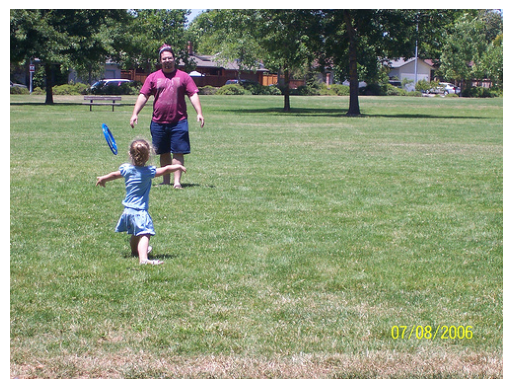

Generated caption:
two soccer players run after the soccer ball
Reference captions:
a small girl is playing frisbee with a man 
an adult and a young child play with a frisbee on a grassy field in 
a little girl throwing a frisbee to a man 
a dad and daughter throwing a frisbee on a grassy field 
a man playing a game of frisbee in a lush green park 
--------------------------------------------------
lowest score: 0.000000


In [ ]:
print("Lowest BLEU score sample captions:")
stats_sorted = stats.sort_values(by='bleu')
print(stats_sorted.head(1)['ref'].values[0])
print(stats_sorted.head(1)['preds'].values[0])
print("BLEU score:", stats_sorted.head(1)['bleu'].values[0])
print("\n\n")

# display captions and scores for high BLEU score sample
print("Highest BLEU score sample captions:")
print(stats_sorted.tail(1)['ref'].values[0])
print(stats_sorted.tail(1)['preds'].values[0])
print("BLEU score:", stats_sorted.tail(1)['bleu'].values[0])
get_cos_image(high[0])
print("highest score: %f" %high[1])
get_cos_image(low[0])
print("lowest score: %f" %low[1])

## 6 Caption evaluation using cosine similarity [12 marks]

> 6.1 Cosine similarity (6 marks)

> 6.2 Cosine similarity examples (6 marks)

####  6.1 Cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions:

* Find the embedding vector of each word in the caption
* Compute the average vector for each caption
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores

Calculate the cosine similarity using the model's predictions over the whole test set.

Display a histogram of the distribution of scores over the test set.

In [ ]:
import numpy as np

index = []
score_final = []
# record the best and worst performance [image_id , similarity]
high_S = [0,0]
low_S = [0,1]
score_similar = [0,0]
for i in range(len(dataset_test)):

    if dataset_test.df.iloc[i]['image_id'] not in index:
      index.append(dataset_test.df.iloc[i]['image_id'])
    else:
      continue

    # Get image and captions
    image, caption, _ = dataset_test[i]
    reference_captions = test_file[test_file['image_id'] == dataset_test.df.iloc[i]['image_id']]['clean_caption']
    # Generate caption
    image = image.repeat(64, 1)
    generated_caption = decoder.sample(image)
    generated_caption = generated_caption[0]

    generated_caption = decode_caption(generated_caption, vocab)

    cos_similarities = []

    sentence1_vec = []
    for word in generated_caption.split():
      if word in vocab.word2idx:
        sentence1_vec.append(vocab.word2idx[word])
      else:
        sentence1_vec.append(vocab.word2idx['<unk>'])
    v1 = np.pad(sentence1_vec, (0, MAX_SEQ_LEN - len(sentence1_vec)), mode='constant', constant_values=0)
    v1 = np.array(v1)

    # calculate different references
    for cap in reference_captions:
      sentence2_vec = []
      for word in cap.split():
        if word in vocab.word2idx:
          sentence2_vec.append(vocab.word2idx[word])
        else:
          sentence2_vec.append(vocab.word2idx['<unk>'])

      v2 = np.pad(sentence2_vec, (0, MAX_SEQ_LEN - len(sentence2_vec)), mode='constant', constant_values=0)
      v2 = np.array(v2)

      # calculate similarity
      cos_sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
      cos_similarities.append(cos_sim)
      score_final.append(cos_similarities)
      print(cos_sim)

    temp = {'ref':caption, 'preds':reference_captions,'bleu':bleu_score, 'cos_sim':'' }
    stats=stats._append(temp, ignore_index=True)
    avg_cos = np.mean(cos_similarities)
    print("average similarity: %f" %avg_cos)
    # temp = {'cos_sim':cos_sim }
    # stats=stats._append(temp, ignore_index=True)

    # update the value
    if avg_cos < low_S[1]:
      low_S = [i, avg_cos]
    if avg_cos > high_S[1]:
      high_S = [i, avg_cos]
    if avg_cos - score_similar[1]<0.01:
      score_similar = [i, avg_cos]

<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3094347974799393
0.18168019725637938
0.204597665738195
0.5180977885269804
0.5211530612177152
average similarity: 0.346993


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.32211865479073926
0.19524394454859778
0.17726177824598136
0.7465740692876418
0.21135380878415874
average similarity: 0.330510


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2134085499393893
0.2696392575122047
0.1902458799609845
0.1645679442288663
0.2696392575122047
average similarity: 0.221500


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.169805014451797
0.37112266585550385
0.9422166180193606
0.4634266081137
0.06695092099006222
average similarity: 0.402704


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1506891715322761
0.04931736863865551
0.09382950866478464
0.11906519584501521
0.2983455825194205
average similarity: 0.142249


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3847526178436964
0.2612301049920944
0.30163187485719684
0.2492730081834708
0.8407008526885354
average similarity: 0.407518


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.0453324237984152
0.521073967415051
0.15132884934214352
0.41604520668895967
0.08512377756529788
average similarity: 0.243781


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.24857568550900427
0.05827678712904566
0.1278337467688025
0.034412327191022545
0.1484429391135678
average similarity: 0.123508


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5265673859490203
0.8342375134312375
0.2035652055205257
0.15048503484155742
0.601321707798598
average similarity: 0.463235


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.22295604806219763
0.21768170809800214
0.31433741875328974
0.36193274756491683
0.22617114158808804
average similarity: 0.268616


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4636011219263082
0.34465088927335935
0.17621560652596116
0.1614806854028497
0.22256602309144272
average similarity: 0.273703


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.33539633192215124
0.8782250711937019
0.7030893312076689
0.180115925464236
0.6631610476077524
average similarity: 0.551998


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.32149267365608347
0.27601161646218886
0.462056340414462
0.5205460289316907
0.6630894758657788
average similarity: 0.448639


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5820909590934799
0.27387112041688133
0.6722442824410999
0.4882988662921229
0.3757342768508555
average similarity: 0.478448


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5072089515083137
0.16941768604240487
0.4505021855605349
0.681483811749182
0.18566926570511463
average similarity: 0.398856


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.15157321424095177
0.20034484515385
0.1467504021746847
0.23463452955157743
0.0729075376893181
average similarity: 0.161242


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.055858671826184245
0.1347971170005774
0.5903095567595855
0.0966848630587764
0.7129227705091066
average similarity: 0.318115


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.28401115712454267
0.3305766655469457
0.3362385293377732
0.6035238506728685
0.7014318301860889
average similarity: 0.451156


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8203813226056805
0.8458119836125934
0.4043530363281814
0.26515900794464364
0.7478666491468277
average similarity: 0.616714


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.19480507877508402
0.2600901276419011
0.07212829989420787
0.0318092245484771
0.1478359393926402
average similarity: 0.141334


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.72970446716864
0.4317319186797557
0.34934012328790953
0.33365935438987904
0.30128310963982935
average similarity: 0.429144


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5755426850485676
0.728725023872702
0.795973736434558
0.7849008074233732
0.687826167205583
average similarity: 0.714594


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8350731902989101
0.977693021476613
0.14098829028992443
0.06035461445720894
0.08469844021521382
average similarity: 0.419762


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7533192363127926
0.03772047200256805
0.033129824101959804
0.23517181641596163
0.07705171134445678
average similarity: 0.227279


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.068342023506294
0.08799726120582521
0.2540867836529433
0.13440206145349923
0.11061458388186998
average similarity: 0.131089


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1934051355172176
0.5630466365657175
0.7293859648476976
0.9217806142070709
0.586103511298927
average similarity: 0.598744


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6704549891960069
0.47700866526621066
0.6454806307202854
0.11515685499892389
0.22235620784544421
average similarity: 0.426091


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2649455827403566
0.39039424551127155
0.2126865795582235
0.5129966440266774
0.1742747912254725
average similarity: 0.311060


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.24653289883051138
0.27724608751815966
0.4662459260081322
0.25099282454429883
0.5432800741264482
average similarity: 0.356860


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.058360152480375
0.006935741771886375
0.10359224706570512
0.9195384020874176
0.02861975929574375
average similarity: 0.223409


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7965316738772263
0.5023135167592536
0.6649407407224395
0.8018576704234316
0.5489809821023021
average similarity: 0.662925


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8065458353162598
0.5745410007029533
0.3384408294948661
0.6744414941106784
0.46207345514974285
average similarity: 0.571209


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.17902676999834882
0.22166723258710913
0.23557139686213777
0.1007847478790899
0.6159493721927717
average similarity: 0.270600


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.39373516183574353
0.7099368510675043
0.1323908830249296
0.2479364749767923
0.7339578760158738
average similarity: 0.443591


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3752676207337766
0.44207224044501664
0.44991751010691045
0.21042358334430816
0.09512655740220333
average similarity: 0.314562


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6160900482489168
0.278727832088135
0.05368064993121717
0.8940484018255432
0.4611673839593472
average similarity: 0.460743


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4948039302344645
0.44374721693977665
0.6115653819968003
0.5711642750013315
0.549525187655212
average similarity: 0.534161


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8445624569751867
0.9108518706272362
0.4853955059820583
0.6846490179863336
0.2301008044339926
average similarity: 0.631112


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.21535996082925288
0.540383443196766
0.09839700786449543
0.5346232341044043
0.08757967321588898
average similarity: 0.295269


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.46089883279120725
0.21005422893377937
0.19197869002995546
0.5531309474150566
0.1277958705164832
average similarity: 0.308772


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.008037537784446396
0.1789878338080294
0.05067314567908584
0.0287631109805775
0.41253211706863563
average similarity: 0.135799


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.07902697024907226
0.4810550756537532
0.582117354799822
0.42424142731743564
0.3525318316316212
average similarity: 0.383795


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3448147231749694
0.28367607764354896
0.8309385095152868
0.6811169290947104
0.19643349233190918
average similarity: 0.467396


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5212971347975043
0.3844898686153591
0.8210078713139063
0.4879627127371014
0.17210397536756442
average similarity: 0.477372


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.15972105308189677
0.17687120843556542
0.20895736521223285
0.3346695329639116
0.14450475633657303
average similarity: 0.204945


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2425981542728005
0.38255138453943754
0.24191363794278242
0.10000815826883283
0.5252397579565115
average similarity: 0.298462


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7113888024132202
0.5495285175905287
0.10798771491812448
0.5719617247474381
0.3581743881635949
average similarity: 0.459808


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.18914813735660183
0.10998296269564567
0.15278472652867048
0.11904161128360337
0.09309787634995685
average similarity: 0.132811


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1086702833440879
0.23326054936553048
0.11959657955812138
0.6212044834675194
0.12071037446608933
average similarity: 0.240688


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.9542099654669556
0.21963219517967636
0.9504286299294641
0.6723083826256302
0.020688771295519128
average similarity: 0.563454


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.316059986127281
0.34365238320898256
0.594595547294461
0.13586301230455486
0.1551451879821773
average similarity: 0.309063


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.18697206105830616
0.26800725948677095
0.8017515124272878
0.19432392875680435
0.07012073057299849
average similarity: 0.304235


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.30181918785092615
0.16124372950951665
0.21775242958879837
0.20976653321772598
0.4819217126348745
average similarity: 0.274501


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4367748943240011
0.24473672279178174
0.996375736768825
0.2954174971319329
0.34847355858482837
average similarity: 0.464356


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8097501570454867
0.21815736131254293
0.5338337909319787
0.5158931959849671
0.5455560228551356
average similarity: 0.524638


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.049915819090427284
0.46333845353401193
0.01636833026496342
0.9100711707197576
0.05372059603516712
average similarity: 0.298683


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.12462654602765388
0.17044096164341987
0.1842948057175887
0.8942510131583497
0.2508951366419625
average similarity: 0.324902


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1278125148634725
0.3486001233201707
0.7347258901168433
0.05191933382230164
0.08083391733384898
average similarity: 0.268778


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5381786269422947
0.923498100092675
0.35609452747485826
0.38245224726925203
0.3616270074360024
average similarity: 0.512370


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.03877368586785882
0.20250416585551206
0.40710874260332075
0.6399575365756259
0.05758329804551933
average similarity: 0.269185


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3824824904458491
0.15141001589524747
0.4724174981250449
0.980894093420624
0.6507366862285137
average similarity: 0.527588


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.49981060466699295
0.5008110113700488
0.9729263241390179
0.7644956068330004
0.3465314108299223
average similarity: 0.616915


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.20539499396648686
0.3560753154656493
0.8101685472506266
0.11676854010455219
0.16628648749390323
average similarity: 0.330939


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.39115737780513615
0.25947392493010624
0.7904732940155695
0.4417950250561016
0.09613620120567512
average similarity: 0.395807


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.44831427061201584
0.3167330129208749
0.10355940567538502
0.3121267618414446
0.5335033657902213
average similarity: 0.342847


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5880960993763623
0.19951206372149155
0.2229407802079409
0.5734334214530485
0.08130453001997599
average similarity: 0.333057


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2546676912920718
0.4743067617000583
0.7075481824059108
0.34802269601883634
0.6779910827899308
average similarity: 0.492507


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4386938303980859
0.22203079874500267
0.2868765074461652
0.6395653163439329
0.16561684777754443
average similarity: 0.350557


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1481658745633998
0.8643431713263747
0.8112751111553473
0.09348734563953663
0.3305727208109589
average similarity: 0.449569


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6854841924696541
0.9935741934503883
0.15178451602267976
0.6139512468345584
0.4897488104932283
average similarity: 0.586909


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.27629510577214716
0.4739239353557753
0.1372717739665958
0.739320393174579
0.3993864301536417
average similarity: 0.405240


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.12289727780002231
0.04558653931211898
0.026587268472893475
0.28205535268926263
0.5320768799259329
average similarity: 0.201841


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7672982509963067
0.13683932704338964
0.640744457815038
0.7501270817772617
0.20479747227352982
average similarity: 0.499961


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6624440747414498
0.31754201915950636
0.4281938611908969
0.45148352637291894
0.5413343193591225
average similarity: 0.480200


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4367623622239846
0.1260029469704962
0.6416867204167629
0.2782174623325964
0.6128432171079649
average similarity: 0.419103


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.34223772218387066
0.8456981676172515
0.21191761278660637
0.6432434684065375
0.48235929919375253
average similarity: 0.505091


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.09238329125662527
0.6183741096291332
0.9276278355311876
0.3569077217518036
0.07720499046017068
average similarity: 0.414500


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.17816950642889012
0.07301522627741451
0.18207112835364636
0.48216851538166605
0.28968536533562145
average similarity: 0.241022


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2553951564587314
0.5258148270582569
0.4156281752015789
0.8251531634575783
1.0
average similarity: 0.604398


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6019628804237616
0.40995938438003277
0.5704606910938558
0.6843049927211792
0.43321018728105315
average similarity: 0.539980


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.0678979506609878
0.12157421598389621
0.2135977249293041
0.846771227982291
0.32095966595050696
average similarity: 0.314160


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.08888024946360791
0.5754126447150996
0.507946309611863
0.1611982894422592
0.19628452904979193
average similarity: 0.305944


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.20088200773497925
0.09143428798237767
0.2359455737575447
0.12117631239220439
0.1796174084832073
average similarity: 0.165811


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.20156991129904644
0.5429090248723032
0.5405994920695293
0.22438561833533782
0.6114577056707867
average similarity: 0.424184


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.45466767334667324
0.9512032574759989
0.6101649985832847
0.532079702180311
0.23175141796025792
average similarity: 0.555973


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.18280542645067582
0.241933805921701
0.35781139535977463
0.5077838875298913
0.13982611092301914
average similarity: 0.286032


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7262648278417171
0.0752232818902929
0.31138618915243643
0.22777100472100317
0.4790101783612211
average similarity: 0.363931


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4995083240965782
0.13841612619954022
0.43688632306418657
0.27365880567305134
0.28975945861761837
average similarity: 0.327646


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.821024343378949
0.4491309211114707
0.4593448819092258
0.4591174663574553
0.48219303694413973
average similarity: 0.534162


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.32254454772141716
0.5420031551547126
0.6422529890515413
0.4166700870706277
0.4055319933350243
average similarity: 0.465801


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5790390567845047
0.17543547726613531
0.1643210196733847
0.14489715879054804
0.622827398154756
average similarity: 0.337304


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.03300413912681121
0.09094092315573131
0.3190207931586789
0.2983921684500308
0.06279822319234014
average similarity: 0.160831


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1397492267166237
0.04043526758666799
0.09685081430251147
0.06456769130029205
0.07283846142124657
average similarity: 0.082888


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.08055206518208233
0.0849079087036261
0.4251447573240908
0.1473624543774599
0.05726961532822933
average similarity: 0.159047


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.02695512318111326
0.48213799952854947
0.012819520787022894
0.07739305944016713
0.6703197686855593
average similarity: 0.253925


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4170760769884032
0.4843099962753839
0.20647005090930126
0.22149863493069347
0.4572761937997953
average similarity: 0.357326


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.13062132536347226
0.1027481771103489
0.07489007154925512
0.3525229851925841
0.2409859929615218
average similarity: 0.180354


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3612793888526639
0.2208261493261242
0.02188200246166191
0.1380398598317102
0.15280458177734688
average similarity: 0.178966


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.22635494939298545
0.2657833226451131
0.07177488615838604
0.534843921466841
0.1767623276368818
average similarity: 0.255104


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6983877558752299
0.1960422942232836
0.5435269640852608
0.2537994291212061
0.06308450196280525
average similarity: 0.350968


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.9173272679937615
0.752008040763731
0.9122232801933999
0.9827927742488562
0.686639272623246
average similarity: 0.850198


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5355697239345799
0.2706126920401172
0.20984634145630598
0.3610706423696205
0.42154206967420843
average similarity: 0.359728


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5993286851238363
0.6182458614171915
0.3344587432859925
0.3360660215777131
0.5532951409265461
average similarity: 0.488279


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.12203743050512242
0.20030039620134962
0.18296171095308417
0.2074696089467913
0.24382536017532255
average similarity: 0.191319


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5381987901943335
0.655385092378957
0.9887754509608501
0.24316949092109283
0.8233035404541139
average similarity: 0.649766


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.30924969393668233
0.8451771862601006
0.1736270800182064
0.715265885010224
0.5398265839640873
average similarity: 0.516629


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.082833341763785
0.7544538794733875
0.45960523632743205
0.21213051747495854
0.7406265087030512
average similarity: 0.449930


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.38984281871247195
0.7237083672111639
0.22896225245325907
0.28067081294112667
0.6031339932725447
average similarity: 0.445264


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7102870805297711
0.10537177141580889
0.4239301369892174
0.4466397034424079
0.7817713559007404
average similarity: 0.493600


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.47692144441053974
0.4859445920613784
0.26024891170251485
0.3699262644054395
0.1692857622142759
average similarity: 0.352465


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.04056313485451461
0.42871227740863077
0.1176893963635709
0.08943004399729482
0.9028261753520209
average similarity: 0.315844


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.16107922666005448
0.7977641890825342
0.8440154344936858
0.5410603008421815
0.7858554105349075
average similarity: 0.625955


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2921808472063336
0.20313627450956864
0.8450526429262322
0.19896668151774696
0.18424011520480632
average similarity: 0.344715


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.17503769129385519
0.12434944176268237
0.05913066273732745
0.5945785869788505
0.17881039506101104
average similarity: 0.226381


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5099362562334812
0.03616125327230506
0.20729580409258366
0.13266873441721244
0.15101141142567714
average similarity: 0.207415


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.41906346175386133
0.07570482605039681
0.17644406057996237
0.7242623961146677
0.729714026794294
average similarity: 0.425038


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.39093330899793527
0.4302080655069683
0.5725739482057799
0.28266130146344687
0.4744131493771947
average similarity: 0.430158


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.20443895184934271
0.3308651035107175
0.12563712678080177
0.39766933287346073
0.7084651749347338
average similarity: 0.353415


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.35110341172326653
0.4680390746359098
0.30940048259873676
0.30571983701264754
0.25339956773841116
average similarity: 0.337532


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3811565133376718
0.40741818035351757
0.025921061083307544
0.15209943898038408
0.07794563823794347
average similarity: 0.208908


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7619235224775909
0.6276598212868594
0.22986644571799192
0.639965791135417
0.1515872201113731
average similarity: 0.482201


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.18950804301361415
0.3283019663382964
0.6744642813931412
0.3359575657073233
0.4311948755324839
average similarity: 0.391885


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.04392161146130585
0.4358850170264317
0.18691967729657627
0.3952676242075376
0.23160178229759118
average similarity: 0.258719


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5438844876237962
0.6181053497254256
0.04226835595828606
0.7921264161889378
0.5441264643847677
average similarity: 0.508102


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.12220143719037906
0.04045393024606186
0.19716049138273234
0.7958761731930216
0.7828659692164602
average similarity: 0.387712


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.44754437841758987
0.5347955501800159
0.3729863563247148
0.5502572336769307
0.4258358464274973
average similarity: 0.466284


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.21010056112139747
0.10766658674686706
0.13816999808304462
0.8209553284684146
0.573959680850096
average similarity: 0.370170


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5661847538256387
0.6088654653928752
0.316538783380122
0.5946007579432466
0.47391291146267844
average similarity: 0.512021


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.23504705016932723
0.11105946185583553
0.09841229334323051
0.1331989344143479
0.1383424552692068
average similarity: 0.143212
0.06806710213525041
0.6893274388841779
0.07464122754195088
0.7588304987456032
0.11054631929225778
average similarity: 0.340283


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.41637729047550615
0.5119866982134815
0.2942174482075184
0.4849796951915532
0.5945025219954455
average similarity: 0.460413


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.251654494505776
0.36164551625742936
0.1323894052068561
0.725192597760362
0.2542891771553148
average similarity: 0.345034


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.38942209986916704
0.06008533098037905
0.3310685316986383
0.1991536115645752
0.2739119330794983
average similarity: 0.250728


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.21800149059356494
0.2505091795299275
0.2688061612643973
0.24136794467573372
0.414818791395972
average similarity: 0.278701


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5614741758028367
0.5160317141138145
0.12368570022687614
0.776750765357092
0.053025729591085896
average similarity: 0.406194


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.061059511189769204
0.34256749301035344
0.04930873155189925
0.22733738165437964
0.14696170236148676
average similarity: 0.165447


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5269802758108466
0.618106300993255
0.14197132534922077
0.11028975126641215
0.12659585709810794
average similarity: 0.304789


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6050522861565938
0.39576733747636256
0.7701236053262844
0.48157832303202586
0.14464822794837634
average similarity: 0.479434


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.15950322821536328
0.5028584414872143
0.0557892077692028
0.6084137775671279
0.3528866658014194
average similarity: 0.335890


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2668985044134711
0.43286598679337573
0.3366578572147695
0.7981840917854235
0.8064733625302828
average similarity: 0.528216


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6608585084495554
0.8829318756666462
0.617559098044979
0.19217381374378464
0.4475276111755309
average similarity: 0.560210


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.10736305827528353
0.10524478527453833
0.16914159910455023
0.09693824517765844
0.08485856324887185
average similarity: 0.112709


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.23837551584818645
0.10733916480084613
0.5341084177049321
0.06717749853306329
0.2106913189764732
average similarity: 0.231538


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5701912263597535
0.7307494932626921
0.5349806110064337
0.4208706368617132
0.37674942702352315
average similarity: 0.526708


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6875687622264025
0.24478040985098778
0.21432018974958814
0.3925162378056373
0.41329112168635623
average similarity: 0.390495


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.21518464064540135
0.22617810662417445
0.08534713451930884
0.8013142116101076
0.22957400170158718
average similarity: 0.311520


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.16756881634604112
0.14630212734388057
0.19349768007965823
0.09379372990913916
0.09616355299291053
average similarity: 0.139465


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.38251412718518424
0.3418675297067937
0.30270192832141635
0.2203475205477792
0.38979476875095104
average similarity: 0.327445


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.32039067561105594
0.7470529061624227
0.43601420212639036
0.11611304298515479
0.502143594286273
average similarity: 0.424343


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6171598209024899
0.20963335081206788
0.37119776109295094
0.37163719022628927
0.20539961573294357
average similarity: 0.355006


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.18178558373307002
0.5724223745476412
0.5967423430595705
0.6007951640372062
0.308654024342466
average similarity: 0.452080


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2987109558268374
0.3369304570156758
0.21965095700693346
0.6056536913895384
0.09957214639488653
average similarity: 0.312104


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.20027480527711142
0.01926673777683718
0.16174377364673517
0.028557437323215897
0.2509579337471348
average similarity: 0.132160


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.27337360254149634
0.1377231111720371
0.6253629489261728
0.27860751766572533
0.893892909759063
average similarity: 0.441792


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3096709330880392
0.8192389106252762
0.6136269985998534
0.3364996325865567
0.1572781921007903
average similarity: 0.447263


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.23547175875110618
0.947889664661389
0.9161775332750611
0.6331902785013065
0.30020324877874055
average similarity: 0.606586


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5892108043631847
0.5238074469480216
0.34037908543265305
0.6187657524983294
0.716458879187212
average similarity: 0.557724


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.37985156722613567
0.34403765016396903
0.5966640898514052
0.31132460749234614
0.5676300992442003
average similarity: 0.439902


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.47899030859823327
0.5236388572582547
0.35932886957403243
0.32662802029550353
0.25204478813797404
average similarity: 0.388126


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4101545258775507
0.4938688544576935
0.0766566077357491
0.497313193353933
0.30520364816193124
average similarity: 0.356639


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4092885330984092
0.32892715679855844
0.27036187012229523
0.4731882641429273
0.46380998422415004
average similarity: 0.389115


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.47924533907766637
0.8420262982905556
0.13463733273437067
0.27521228610254456
0.4344175239345549
average similarity: 0.433108


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.27229945752028895
0.21648292578340542
0.17502983734085617
0.22721014390018204
0.17694948592450652
average similarity: 0.213594


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.0586256801158943
0.19177325005334156
0.35189761578221046
0.2653358411518365
0.6110999055521443
average similarity: 0.295746


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.16152883594159811
0.9299362914793814
0.21171022842559728
0.11799886610006746
0.09444862363165
average similarity: 0.303125


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4914905651390119
0.5700951726463375
0.314026407743499
0.5843740968201436
0.5054545955506496
average similarity: 0.493088


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.08307583220088488
0.7921848996876172
0.4168329503622383
0.37274069888907524
1.0
average similarity: 0.532967


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2773525556309562
0.13101910082246326
0.1459642882315346
0.06806269546388825
0.4301244773507509
average similarity: 0.210505


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.14373775105319053
0.16638443360522193
0.12433561176948488
0.8814224293863835
0.013248557904851542
average similarity: 0.265826


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.13982347963743125
0.13072580074331192
0.1762269559038224
0.371757866064599
0.10662803667920388
average similarity: 0.185032


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.20946061400729063
0.2664599576951886
0.1736261453745808
0.221522544534031
0.46933001518163975
average similarity: 0.268080


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6711738909945195
0.35348833906437727
0.3214234507167881
0.47252975857473095
0.12232934646936837
average similarity: 0.388189


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.09392118375176399
0.09207493025855552
0.18444236106217515
0.14790616610046403
0.1911853001935753
average similarity: 0.141906


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2614428721831849
0.9405201942550052
0.4036027159734881
0.8114110595332316
0.4175070391223079
0.34772919646344824
average similarity: 0.530369


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4524008742824574
0.6847379279756227
0.5035393066244402
0.14569833079673666
0.09609911296472645
average similarity: 0.376495


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.05499355091367342
0.16729419649320937
0.2916924430459375
0.028779163130772552
0.4806127272538392
average similarity: 0.204674


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5380632991841653
0.10212652947786477
0.731036875698877
0.6755342428058313
0.6863095939043203
average similarity: 0.546614


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4827161243782992
0.5597540616725258
0.6763315317402263
0.22476509324853572
0.4012876484416719
average similarity: 0.468971


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4848581692022402
0.4437988248383015
0.41974689460856945
0.6102396748156342
0.7640172050853434
average similarity: 0.544532


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.9523533735680203
0.19861115317304734
0.9687925310218916
0.061448529371322905
0.4071637393484821
average similarity: 0.517674


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2233904710319255
0.5781653220167683
0.2109994297776098
0.56142160201769
0.41319280843634065
average similarity: 0.397434


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7076921059427299
0.3240727911087908
0.4040605894755233
0.41910143548586765
0.6615242274094231
average similarity: 0.503290


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.04545328539402446
0.4269624937414757
0.7029936191103595
0.2665595940874513
0.05762268550395016
average similarity: 0.299918


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5705350361069857
0.39485498918930273
0.5284089664281582
0.0835373405638558
0.12600670312147563
average similarity: 0.340669


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6810293104457673
0.581536463918586
0.33972754614009454
0.14521560399319122
0.6506678221481207
average similarity: 0.479635


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.35837798050326397
0.022905694240201054
0.029742229727890448
0.25249975992508156
0.029763544700517532
average similarity: 0.138658


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6746998103409925
0.46163878519127394
0.7121169506699694
0.11505776991042327
0.5560617798487909
average similarity: 0.503915


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.13010537053059712
0.6493757333353519
0.3492447933676978
0.16979978117967826
0.15050680020651416
average similarity: 0.289806


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.35086835323131005
0.6683981742565566
0.5227930611214586
0.13198665488628292
0.5121123289942126
average similarity: 0.437232


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.26524212678142406
0.44282587793565675
0.20208454178010093
0.2938583647771196
0.5040061973766111
average similarity: 0.341603


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8286881468916137
0.27443493387914514
0.5289627332650154
0.6127293737770315
0.17098168460268193
average similarity: 0.483159


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.11716937899844404
0.4114564676535019
0.23710948016614608
0.625989734029973
0.2704290357535964
average similarity: 0.332431


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7593076873590991
0.36719389348341297
0.0778315630497041
0.376152162173873
0.05495187645087441
average similarity: 0.327087


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.902641350081734
0.5915143936273395
0.043771929506711243
0.4388149842081245
0.0829249145486283
average similarity: 0.411934


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5192345602507135
0.4903026987186794
0.1567270644096126
0.19649453546968795
0.045231922474866355
average similarity: 0.281598


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5488761961492514
0.7429806209781057
0.21940939607611457
0.6374965307335445
0.6384956989157835
average similarity: 0.557452


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7721267402555596
0.4885799182576451
0.46682328826397773
0.4383848108958419
0.5852145721517675
average similarity: 0.550226


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.14829578126980578
0.3357051271679003
0.06391520723474373
0.42607085246262894
0.09315898354875889
average similarity: 0.213429


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4263468541470589
0.24886311811386333
0.11616967820081206
0.12404879852421455
0.11695355209331136
average similarity: 0.206476


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.15186722538231892
0.1033969884150149
0.9445036863945487
0.8982217616664843
0.0839646853134691
average similarity: 0.436391
0.09242762276715324
0.14188329027777857
0.18415751502163133
0.7704540741240071
0.5440343590703822
average similarity: 0.346591


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5247891856434957
0.1933821330151937
0.17048854544634262
0.049855215624415514
0.5372059982081395
average similarity: 0.295144
0.6271461841497153
0.4587598848708007
0.762833365797651
0.8350407081912512
0.8483621465862233
average similarity: 0.706428


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.33742762916952024
0.5496283235004187
0.3082604559736449
0.05647658117251175
0.4242548014340343
average similarity: 0.335210


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.0717490471301108
0.024118388808317355
0.13640246753948432
0.3559426707139338
0.19675060868293884
average similarity: 0.156993


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.05670924336543563
0.015127458897610914
0.6305140044487599
0.012088218674478712
0.06027788728417036
average similarity: 0.154943
0.8470218153615434
0.5371836518534491
0.5140890893716318
0.5783543643110218
0.8471722035324547
average similarity: 0.664764


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1272695893792273
0.39123470355172735
0.3505220560652926
0.6486458918007182
0.23914459814058164
average similarity: 0.351363


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2862806483274358
0.2613622691793906
0.31121497912423773
0.3314327903411695
0.5016961450703697
average similarity: 0.338397
0.06386216871116997
0.44781401081522726
0.3457329538615306
0.4846462700230742
0.12517297879396025
average similarity: 0.293446


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.07091723228767537
0.15440270341371973
0.38937794836083145
0.06874857193787037
0.25464484038035345
average similarity: 0.187618
0.23389792351523597
0.26516992588051674
0.1499469356648744
0.31740959962903686
0.27983069965755325
average similarity: 0.249251


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3750114165863789
0.49942142672556294
0.6477916693416503
0.5502362252832815
0.664295398997002
average similarity: 0.547351
0.20064191098183878
0.13779659568679975
0.7575791569284973
0.4060145153966305
0.15970077797145413
average similarity: 0.332347


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4938939975852362
0.13395379835136076
0.3611656381318819
0.256505299300801
0.2923099692520266
average similarity: 0.307566
0.4394501983672525
0.6088668280094447
0.6587584923320786
0.247590905880594

<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)



0.7527355100907898
average similarity: 0.541480
0.0852570909098433
0.8309739327698277
0.06271099783303648
0.6884238995079373
0.3989864511169497
average similarity: 0.413270


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.46909325056643214
0.7064997577758885
0.6590350913814425
0.17537204842995602
0.3079791034335008
average similarity: 0.463596
0.5543949675934889
0.7489848087352096
0.4718867584131114
0.5970368358638453
0.9146850311083704
average similarity: 0.657398


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.27776900457981435
0.8816174255921609
0.6751434729027707
0.2923960679319841
0.884591321865598
average similarity: 0.602303
0.22562605519887521
0.7601224742318481
0.12484701082417432
0.5924355559288763
0.43469534813936106
average similarity: 0.427545


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2235790456453528
0.2584466054239887
0.5687246626849264
0.2534263609034317
0.6193362746628711
average similarity: 0.384703
0.05641666599784026
0.0695418471421736
0.558231057233467
0.6419205675717199
0.18455396099666482
average similarity: 0.302133


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.06596651690689637
0.609871419615693
0.23933493897617547
0.5776331930204005
0.08273207156534203
average similarity: 0.315108


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.053049401579407
0.6078384984802115
0.7784419168511264
0.07218789714278025
0.29390793300007084
average similarity: 0.361085
0.2621498978197192
0.3258687046441377
0.25537477265599995
0.3012753735092069
0.3110050312650639
average similarity: 0.291135


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5128332071694535
0.5177732327053288
0.4767605443049258
0.7040009564072348
0.9162740936406956
average similarity: 0.625528
0.322482710479465
0.5238653682753845


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.32580700642471605
0.4104490582690645
0.2905931080883791
average similarity: 0.374639
0.029449045018515117
0.1438543350711758
0.3206258130033125
0.05448892954857988
0.11420265728151482
average similarity: 0.132524


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.06704129689679865
0.043708668494071054
0.3416228212436559
0.4031625800830009
0.1825423434548029
average similarity: 0.207616
0.8518559042038274
0.13412164743794322
0.23974288079895262
0.13016518556916667
0.2803588511064607
average similarity: 0.327249


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6122097439913194
0.15925285286757884
0.8328709833985782
0.36743127577123985
0.16465716270285366
average similarity: 0.427284
0.41316596227196245
0.18044695780873077
0.5350531669557049
0.3275333963001035
0.17721579380746189
average similarity: 0.326683


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.14011979415924988
0.08037053842205373
0.45957378543829985
0.42229182438828555
0.4564653484499696
average similarity: 0.311764


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.018666586437934805
0.4333322703831246
0.02022410744648289
0.6785446549395507
0.10073970096655989
average similarity: 0.250301


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.31635282359756356
0.4422812162551154
0.33199591441362364
0.619529856525872
0.052633074458176866
average similarity: 0.352559


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2424127067614211
0.0375782960776404
0.6639983903866042
0.39617761287089914
0.2875757439427152
average similarity: 0.325549


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.13534194369016714
0.10999303898321781
0.1786442285553514
0.27341244899271105
0.193112082009565
average similarity: 0.178101


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.18205818926937162
0.16428985663599543
0.9966162164263697
0.0313725728241699
0.35176043668482865
average similarity: 0.345219
0.7859963033638775
0.20481824446983035
0.38345843299656024
0.16424934262083604
0.09293974629447226
average similarity: 0.326292


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2501021396554157
0.3153279548635328
0.21373223991647197
0.47975887484375385
0.8637442730816509
average similarity: 0.424533


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.056701923229297777
0.142512785268686
0.1427780084742845
0.4148207763775872
0.2813095745646042
average similarity: 0.207625


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6495633978798003
0.05228216571753887
0.031497504380333795
0.0810092191417669
0.6972549830159476
average similarity: 0.302321


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.41460150039642335
0.20566891683642383
0.4522300263773125
0.30632497090010197
0.666513091266469
average similarity: 0.409068
0.1216615627302112
0.4698845736550716
0.5096849468977593
0.18038228297336778
0.12294086305486678
average similarity: 0.280911


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5228265509614347
0.3062398856163796
0.7191008667744789
0.3242414120827461
0.4563339257110586
average similarity: 0.465749


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7810880324331618
0.9852506774371071
0.45818074140017306
0.17260142831311193
0.08819697791202563
average similarity: 0.497064


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2415121837906365
0.2349328250213376
0.20963598378509363
0.2533829257000479
0.2655797031583026
average similarity: 0.241009


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.16080971698513116
0.40298820944337427
0.5309934971136323
0.24464385174567724
0.30224584887698314
average similarity: 0.328336


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5125084116073839
0.34687705250078976
0.23581232000163543
0.22519736943106566
0.7073436958946483
average similarity: 0.405548


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4410685378119962
0.2568977543935819
0.5573348794492288
0.32600499889931817
0.23486038794496145
average similarity: 0.363233
0.45220206896547416
0.057498229571922445
0.14834458121026495
0.044565141154732306
0.8297206635371698
average similarity: 0.306466


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.902244409338365
0.5654863645698622
0.6087930003276668
0.8254024311493674
0.35855289328876827
average similarity: 0.652096


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7504127552261185
0.16280522854007176
1.0000000000000002
0.16666486946034673
0.21665790625941905
average similarity: 0.459308


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.19482789053423843
0.31540917109360284
0.11502350537357331
0.2336303155619477
0.557289237072944
average similarity: 0.283236


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.21907813630902237
0.39755178407789893
0.3979270869244
0.50449448822431
0.3884831005571739
average similarity: 0.381507


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.44022295764081165
0.29181809630775185
0.34051624819158527
0.4394950696607694
0.18240554537209952
average similarity: 0.338892
0.18347876089936796
0.1719524294642033
0.5906601279941339
0.7112305726858891
0.08501815197469183


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


average similarity: 0.348468
0.4659261117945739
0.5799081784794513
0.647434477055931
0.600927977830431
0.5215164055631477
average similarity: 0.563143


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4663689613043966
0.7892881658381993
0.32038486528932664
0.41068236520165985
0.36486494875460285
average similarity: 0.470318
0.6925088572562358
0.3429140929486209
0.10480111857211089
0.21019664408791316
0.4312150055880622
average similarity: 0.356327


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5464812400297272
0.8898627656079027
0.43827130965017086
0.5466141170682457
0.3492809040913494
average similarity: 0.554102


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.162731913322743
0.09243056297299722
0.9997186211399925
0.2793845607199099
0.23512235981573862
average similarity: 0.353878


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.17886484301988365
0.17241626467333213
0.2864068623967306
0.21017595042864914
0.27495355518826964
average similarity: 0.224563


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5508331341077033
0.08884297041741286
0.2286630330777771
0.9789336970154973
0.9342015365799295
average similarity: 0.556295


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.39112228689636036
0.5714768990974177
0.2156968255328977
0.342622317385605
0.33481582445956354
average similarity: 0.371147
0.009492531799505762
0.06202741996733732
0.21024207371277218
0.7391514951733011
0.11528543443682841


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


average similarity: 0.227240
0.010720268084088711
0.1439387546471419
0.12973484543893615
0.19555748045209134
0.14024365346802062
average similarity: 0.124039
0.15260346835340013
0.06363757730554798
0.21375155472165605
0.062968535535197
0.14113397528499666
average similarity: 0.126819


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2954078974619733
0.5721063027357123
0.3224148747042011
0.27997135923448785
0.7157434969385901
average similarity: 0.437129
0.249977025728967
0.5611917927717237
0.2586120086516966
0.153912686548864
0.44646741328162354
average similarity: 0.334032


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.47062094171401764
0.13452277324607279
0.07463297619137754
0.2762338296398087
0.22226859370778865
average similarity: 0.235656


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.9021092430955135
0.0961477252639247
0.28747016157325195
0.8170655583026498
0.3481957133531353
average similarity: 0.490198
0.1430557779733601
0.65000625663466
0.5962187883977461
0.15605436715876195
0.8518106368542301
average similarity: 0.479429


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6629315693251057
0.5964862906448136
0.3883443970237876
0.4168736321109833
0.2538342053028945
average similarity: 0.463694


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.9675675350820646
0.3921163997059441
0.11495419803938078
0.3216810777228833
0.3964871942369617
average similarity: 0.438561
0.11445328848774923
0.7370688848836238
0.047357754286187895
0.23814132276469882
0.6307039838126413
average similarity: 0.353545


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3348303449414417
0.4496116695262465
0.3984515494996486
0.6145555418656452
0.7822693143782723
average similarity: 0.515944
0.2631680663405443
0.4658974129703942
0.7823533061418682
0.5051407561867243
0.2053641199408405
average similarity: 0.444385


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8731486360467543
0.49673785385273767
0.03048983502705906
0.2837713988080453
0.027745427155792157
average similarity: 0.342379
0.07071559690514262
0.4697504171733061
0.5718286536576351
0.05543540496045939
0.3596296639764359
average similarity: 0.305472


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.38672994398282456
0.4929845594045288
0.9083727799399572
0.24426746004351757
0.27709441854449574
average similarity: 0.461890


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.24248227988212498
0.08148305094759913
0.1763796343016254
0.04262953568871539
0.5759997463346944
average similarity: 0.223795


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2551269725426591
0.021261418547162902
0.14995353014704446
0.03569194165747004
0.3068579929123775
average similarity: 0.153778


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6984625182695536
0.39657339297537103
0.11576779888955446
0.21810412680150598
0.5509118361201437
average similarity: 0.395964


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.35366129703704335
0.17945589700371958
0.42808558502028043
0.18379210616961367
0.4239485926228871
average similarity: 0.313789


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.28571191552775865
0.0066575458102999825
0.02922723973618776
0.4244858478820945
0.04095578250105711
average similarity: 0.157408
0.4153755002377096
0.16283397764303245
0.5236046790591136
0.7297096643087028
0.8354841848362965
average similarity: 0.533402


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6438429643066196
0.4061108606287432
0.3550971358463394
0.3142182896876889
0.5431114966502051
average similarity: 0.452476


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7764330365726269
0.7553445580148713
0.5067961073659987
0.3907337203892858
0.5382563649603067
average similarity: 0.593513


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.37067217677188646
0.4011511693864255
0.3160590469468647
0.08904585824245483
0.1279301053702813
average similarity: 0.260972


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8559625436036294
0.7952574148033632
0.5036912515350331
0.6839244546443021
0.9263577350786152
average similarity: 0.753039


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.07571819780903125
0.23743575432405487
0.14686229316656393
0.7676569315123035
0.17066523029068492
average similarity: 0.279668


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.03786655742361055
0.14242953510446063
0.25311516016405944
0.05343633843654869
0.1599477546885044
average similarity: 0.129359


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5484298209820503
0.5229970377144717
0.5634523762141153
0.4951643151051366
0.871864256846019
average similarity: 0.600382


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4450742595206189
0.23732562079055003
0.43027097097394457
0.6076210443994468
0.8046757864178099
average similarity: 0.504994


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4575548153430552
0.41546696068853506
0.21648705238342228
0.2421029968999244
0.7393950950377148
average similarity: 0.414201


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.12244018477423503
0.22629815064585723
0.09359858897134259
0.1617133887216149
0.39206438173443997
average similarity: 0.199223


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6050208139280211
0.7597353221150064
0.9424640961502668
0.8753059806837362
0.6979432709977632
average similarity: 0.776094
0.08597982384245863
0.5961373079952135
0.20976255031079902
0.1275292343544568
0.9060222592064159
average similarity: 0.385086


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.9688987438943621
0.7625557973328748
0.21296447191915735
0.398811469355128
0.13535265856209877
average similarity: 0.495717
0.4412626294434984
0.448141017845141
0.48353108602346795
0.4089852603878712
0.18283650154325143
average similarity: 0.392951


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.21684214034472335
0.24704938079025615
0.34547771993271514
0.9495111731309066
0.6614265601863353
average similarity: 0.484061
0.18869092241267152
0.11089346883440152
0.4430535564334265
0.4876700317595237
0.3206379827455739
average similarity: 0.310189


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3106229445690616
0.19365377999215533
0.17826400115981045
0.04126171739894079
0.3559036168059704
average similarity: 0.215941


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5269809558719583
0.8448323929253035
0.9776002989266159
0.40850328144525816
0.05358827007163234
average similarity: 0.562301
0.24324825685176607
0.464597589318318
0.2652901461981359
0.7578800991469318
0.3238254301974947
average similarity: 0.410968


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.477974052927527
0.4379330078662986
0.7205474694170957
0.350069358104154
0.39632907432198683
average similarity: 0.476571


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6919425946534623
0.2530438417680845
0.238241018762715
0.3833321237192269
0.6554723365244034
average similarity: 0.444406


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1108946687087708
0.07326565210167107
0.060300938667903384
0.6429032711588795
0.07036890100947617
average similarity: 0.191547


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.38455504701075627
0.20638886450556151
0.43473756280422343
0.3212001522398365
0.5649730470063202
average similarity: 0.382371


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.24655894283572827
0.22347580789505497
0.9165248870878192
0.17085433962832594
0.2137181866273513
average similarity: 0.354226


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.22766898220005916
0.3002398340246539
0.05875339576081032
0.3903404149816989
0.2835041105429425
average similarity: 0.252101


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.06472193469433755
0.9000809971332212
0.5492532658540308
0.4692740559237549
0.07782697319745181
average similarity: 0.412231


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.0919143346230179
0.2518672242526789
0.2963198290986156
0.22381983059721
0.9574024848957002
average similarity: 0.364265


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.39168122958721807
0.2160598513260249
0.5252464581711279
0.45472456030365943
0.08600340392168528
average similarity: 0.334743


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4687764657270205
0.05951753590638126
0.07905553710416796
0.6843210250903666
0.943564022751011
average similarity: 0.447047


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3935110644681939
0.07615880557971734
0.213616963562838
0.1409978057568453
0.318755127272436
average similarity: 0.228608


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.45591439715463195
0.5416627430774633
0.3066670465830139
0.2600323638068906
0.2044772285553867
average similarity: 0.353751


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.16502951476849656
0.9405436915055284
0.05983025438024251
0.010850287121934801
0.24069821948151576
average similarity: 0.283390


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6656410183160264
0.1654292898483343
0.27703967567668314
0.21119124033039793
0.5306442215337231
average similarity: 0.369989


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.04019026025611938
0.41751937205617085
0.19828706507991478
0.3052148437352736
0.45303065842732293
average similarity: 0.282848


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.10534967871773179
0.591531513141243
0.8075809861651896
0.29879647157345857
0.19798449923449463
average similarity: 0.400249


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4823036510304604
0.5928197760400803
0.35723586649301203
0.04467092763773136
0.0949240261764765
average similarity: 0.314391


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4479207968958387
0.031021682630803262
0.11956551946577029
0.16995047464995097
0.02799476530642209
average similarity: 0.159291
0.3447755631529765
0.6309002141472045
0.7896941102875916
0.16569209211917454
0.45031492456566374
average similarity: 0.476275


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6988707317962392
0.6083294797837757
0.5213791156695925
0.42702757049184936
0.6058988060712717
average similarity: 0.572301
0.18840918318424454
0.33002330142361114
0.9198091237287893
0.01904353188066509
0.24763847176875187
average similarity: 0.340985


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.03606376549901197
0.03420118025723968
0.8492954031381396
0.02785351072584776
0.1372041991713426
average similarity: 0.216924


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.45614489685950477
0.29667179681310624
0.6134479499153295
0.4684117091436652
0.6725720878456604
average similarity: 0.501450


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.07955166186113864
0.20800791181854755
0.47483717277669873
0.06536413009930689
0.10791571182059065
average similarity: 0.187135


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.19691858199248188
0.3369515488617357
0.39081696005701755
0.10471565264894481
0.7243236163844087
average similarity: 0.350745


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.28434316682179284
0.33857712597559453
0.23645942152830007
0.4298709230062733
0.44539683417235937
average similarity: 0.346929


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.17817234684699063
0.16680596628480646
0.20702187760549964
0.22158931020848985
0.3936263135143793
average similarity: 0.233443


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6939744347491077
0.6435502669425557
0.5358402059043311
0.1301228506444324
0.2693157120340884
average similarity: 0.454561


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8599399298590586
0.14237643462101723
0.08823624125564322
0.1313445367475076
0.48419330132311683
average similarity: 0.341218


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7453695173833481
0.15579884367030675
0.26245368446492506
0.7375707668708869
0.2736111332178933
average similarity: 0.434961


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7718614263409368
0.5375130470390884
0.15500422836571665
0.3572348810732915
0.3339633073700798
average similarity: 0.431115


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6276366748734901
0.059285766068859345
0.09297641052195114
0.07295466277735982
0.11294496878838166
average similarity: 0.193160
0.5637116615118207
0.15252731823519966
0.6218037662655871
0.523003430518823
0.6646912165843857
average similarity: 0.505147


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4888618344096532
0.3139805743014568
0.4513700464682948
0.5856228275372144
0.5027332159345089
average similarity: 0.468514


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3695294899067308
0.8718845248459325
0.37661600058278294
0.7627205151736139
0.1379485944894732
average similarity: 0.503740


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.24481291601264335
0.45707847315762945
0.08907969487905479
0.13306898124270503
0.1115103926170191
average similarity: 0.207110


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2598088339802031
0.23569838667592444
0.8683696847789129
0.128598419256134
0.36540547856029865
average similarity: 0.371576


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.17242663576269798
0.05270239254676894
0.060490069160172404
0.6110405317969955
0.08836233982513929
average similarity: 0.197004


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3484003751283094
0.6192395826180135
0.10181558171461116
0.16788960927337598
0.42282328289110527
average similarity: 0.332034


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6438227886273178
0.5569386576901202
0.3812057790444033
0.4532508047744392
0.730412639601314
average similarity: 0.553126


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.19101208457331487
0.7720234554731542
0.22375205907597195
0.17649551386725534
0.5271365581236099
average similarity: 0.378084


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.10273623816771969
0.09281732224375425
0.22741257892461667
0.09430070725336616
0.07935085723915451
average similarity: 0.119324


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.14254746272858462
0.38181650678028933
0.5623437000488309
0.056187556650042894
0.36167369620629225
average similarity: 0.300914


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1272062073884645
0.6900932011024505
0.3723754851257088
0.7144974301414811
0.7769422446248267
average similarity: 0.536223
0.06641418656745882
0.6743005440541506
0.38009408621900437
0.07964202246690949
0.727874290146126
average similarity: 0.385665


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.10245964209412019
0.3107415898879667
0.26579773774901944
0.6742010841986579
0.21645717146073618
average similarity: 0.313931


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.13023904999378366
0.8615852068208704
0.282010062560981
0.5319954479722518
0.04128610165392061
average similarity: 0.369423


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.48278330580011314
0.4661351529008791
0.49731721791426514
0.09740925997092637
0.7374184083589573
average similarity: 0.456213
0.5012860667592818
0.9894388360489436
0.29139882715701443
0.027808097407764847
0.7692301672902224
average similarity: 0.515832


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.14923285977819634
0.32645135188177127
0.13987371277484725
0.34362844457188857
0.285591028258957
average similarity: 0.248955


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7487414376150234
0.2749960910678036
0.9483621706997156
0.2620796376306204
0.17252998510347212
average similarity: 0.481342


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.24584010813326865
0.05725369270620756
0.5865476103211785
0.42673470282352083
0.471748520570315
average similarity: 0.357625


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2216603269228054
0.7421501045127964
0.6004004967248205
0.8998470670426194
0.3692763472882148
average similarity: 0.566667


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.11443265300663297
0.23114022805001855
0.9999962682454283
0.4383521049331771
0.5309944525252679
average similarity: 0.462983
0.22829719128773968
0.34339155409874467
0.5750383951021986
0.7884104794974716
0.6155836104768945
average similarity: 0.510144


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5353216726308129
0.592324449926447
0.532370259378433
0.6071683589823875
0.2558917308004229
average similarity: 0.504615


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4239081298487902
0.7966513331461632
0.8133907107675046
0.10502786694084866
0.20471518955501206
average similarity: 0.468739


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.0579343602726586
0.06030034150624263
0.058123118755009286
0.6724406274250044
0.0685970402267748
average similarity: 0.183479


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2226025946968708
0.7118085894938365
0.06604055180616814
0.1408862567276938
0.06120311654389239
average similarity: 0.240508


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.110857810021877
0.03967009248369669
0.5627433166093201
0.5333513018816204
0.9999999999999999
average similarity: 0.449325


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2646646863907122
0.4588241357462222
0.26499944058440056
0.32329336271695996
0.21374095283054437
average similarity: 0.305105


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.09749051472034352
0.029096588305911587
0.035696811545209664
0.439610645705949
0.08869556337379943
average similarity: 0.138118


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.26293860903608
0.05707265734758467
0.7966519301556362
0.9049981788924725
0.5525448388766168
average similarity: 0.514841


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.13338716153696087
0.13651998529070428
0.725975574465606
0.4118851820522403
0.7841196009603324
average similarity: 0.438378


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5934651090841473
0.5977156800389499
0.0986082969159997
0.27913809153231667
0.41017169469866827
average similarity: 0.395820
0.40260053204893415
0.01690822033885875
0.004837467449473994
0.35471928589469504
0.689242436813986
average similarity: 0.293662


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4164878342948283
0.17272387087735197
0.6346087277562871
0.784778444598272
0.8579728661646628
average similarity: 0.573314


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3726105421517396
0.3725100068013537
0.8888558928997868
0.575457777423928
0.6180131058857802
average similarity: 0.565489


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.022280718574596934
0.5159893283369713
0.29040521576933176
0.3061773110026958
0.2976242104866471
average similarity: 0.286495


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4262448154071527
0.23078788951720744
0.11942919275515196
0.1725438693342566
0.10543734169529177
average similarity: 0.210889
0.5511693158962314
0.6792408934172016
0.04150898299453583
0.06281623790274417
0.15554641316395706
average similarity: 0.298056


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.16575653476338806
0.3848062279840653
0.3285479426495968
0.5130134881700776
0.2533007038682479
average similarity: 0.329085


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.23208513444997317
0.6579675343477898
0.7075325162882623
0.9991709327538039
0.2614228672761528
average similarity: 0.571636


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5397755203995735
0.014874162357134806
0.12858346689292596
0.09918487376891291
0.22638311468773073
average similarity: 0.201760


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.439004263405107
0.511980401183934
0.48515283966764405
0.1863734750442697
0.48007085407533723
average similarity: 0.420516
0.1103943358157652
0.2624305501807747
0.4049152559197981
0.45927736366592903
0.35638840022559576
average similarity: 0.318681


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2509296472150406
0.19813017285987944
0.6382922534076547
0.8786702282902872
0.14228096865666562
average similarity: 0.421661


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.23705253757322162
0.17199851185381462
0.08518534639133547
0.40471609325060504
0.638531307344507
average similarity: 0.307497
0.23313408660136367
0.5092125162960884
0.30669267058366195
0.8485599680479537
0.0589801068045471
average similarity: 0.391316


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7058675550486072
0.4653628526512757
0.29091913160853144
0.27575492511897365
0.4577479986689818
average similarity: 0.439130
0.16378914190330596
0.11721292027384611
0.07556240228449769
0.07771101497617836
0.2633515989246119
average similarity: 0.139525


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6228973172922904
0.05497510369437647
0.6079274854581485
0.20760168751503918
0.2993909405345688
average similarity: 0.358559
0.7810407791629723
0.17077073188754963
0.171071225462187
0.3165006717400488
0.6204736895591831
average similarity: 0.411971


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.23258727827310427
0.42373791878769884
0.17274079585422353
0.3172569857421265
0.40980330908939594
average similarity: 0.311225


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.19180079771284006
0.8911700437954232
0.053298871845273
0.4477114018966671
0.46537570907264286
average similarity: 0.409871


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.39992600561985425
0.11579467566216652
0.18821653540115293
0.5685177672643654
0.21697207469191748
average similarity: 0.297885


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.30677552687407245
0.43426256084269477
0.5125527026341958
0.367337479559505
0.4454697610199546
average similarity: 0.413280
0.2594729334518144
0.2960989306896115
0.26512426175601717
0.22451237311679836
0.9262477289021299
average similarity: 0.394291


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.07678222414120203
0.008463497348428755
0.004258053579205053
0.06600589439641547
0.13166953726148786
average similarity: 0.057436


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.01868698309330323
0.7896209482361684
0.13977925626643037
0.01838055396168619
0.07841453179942809
average similarity: 0.208976
0.03238088340469243
0.18408496297326485
0.1379628596347532
0.7297173191895024
0.46264190510574094
average similarity: 0.309358


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.06990703005123765
0.7845959870995247
0.41758322814958515
0.2977489376549905
0.10929988414454277
average similarity: 0.335827
0.6667495142943216
0.25287219378293013
0.36397388056029284
0.06496328959673937
0.8577303929711657
average similarity: 0.441258


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.0851387102412174
0.6431706766396774
0.6980429235253469
0.9736179081466096
0.45278671254260533
average similarity: 0.570551


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.643006174826199
0.5859239001162377
0.22886893830390914
0.6878776318027074
0.48521650433950536
average similarity: 0.526179


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.10477268029795593
0.11484594218761894
0.13641737546937938
0.10602274578878522
0.175713628014047
average similarity: 0.127554
0.25174585269729255
0.20451389712318616
0.25174585269729255
0.6673184938442295
0.14289245314971383
average similarity: 0.303643
0.2623694470684367
0.554701580279188
0.286015778380107
0.7234785206632194
0.34051670308776794
average similarity: 0.433416


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6097587277617051
0.05404066209521371
0.37522692787817824
0.5128136956616688
0.05698997953154327
average similarity: 0.321766


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.20036350447753226
0.10034597019824001
0.15426420335980603
0.2411521396249708
0.12952877301244523
average similarity: 0.165131
0.1309049664599159
0.2813681505516056
0.5780633676260588
0.4074720267596672
0.3097992917019828
average similarity: 0.341522


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3108589643070381
0.6714533767375124
0.836412194263822
0.2033699060125239
0.41875668847528164
average similarity: 0.488170
0.6140531237790151
0.1865619513473526
0.36970070662087323
0.9441834696955983
0.5004622891966943
average similarity: 0.522992


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5904348060025691
0.3430609245045349
0.40420051346104097
0.791423538888808
0.24963000410529101
average similarity: 0.475750
0.9535717658912699
0.11417754707773702
0.6884931593705831
0.3625062242874364
0.1094562687621552
average similarity: 0.445641


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2674157841729299
0.30869714150843997
0.7847794900928231
0.145300617242334
0.04013601836970646
average similarity: 0.309266
0.35576523562290013
0.07769382517372038
0.37305023839078383
0.21844408463735576
0.12657157064450555
average similarity: 0.230305


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.17913045264779107
0.05928522476393459
0.4536638676299846
0.5805290263341866
0.16145096164381
average similarity: 0.286812


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2699191310011361
0.9105375879816123
0.3141250109737422
0.2307289288159493
0.49654174183801764
average similarity: 0.444370


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6527609300049596
0.05723371613590182
0.8589923927658408
0.3278310966693925
0.25958803857040375
average similarity: 0.431281


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.049581096727604225
0.2875707582761238
0.2060360767320421
0.07824527473189963
0.19557841232775683
average similarity: 0.163402
0.43690698016584684
0.36972207442018495
0.594032215707903
0.49446654342111585
average similarity: 0.473782


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.07650236043764827
0.8033520456534583
0.9553810980701445
0.5385699499304006
0.08530141617112726
average similarity: 0.491821


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6557340049070158
0.7887053615897854
0.2678168484002487
0.061802798084955535
0.13290502142185476
average similarity: 0.381393


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6438551121922292
0.08435652426693245
0.645000913424183
0.7218608922215154
0.6601841296490255
average similarity: 0.551052


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.45570643889514695
0.2447407328468447
0.2942590373911328
0.08954383054500945
0.2791196258531628
average similarity: 0.272674


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5486809170415196
0.05987155389448054
0.7496339832881797
0.5109678741812431
0.5284995732910865
average similarity: 0.479531


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.42475028691187583
0.037825843603878286
0.14729500678770382
0.16532387178270294
0.04545982928605593
average similarity: 0.164131


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.49202475127735135
0.6923497968262304
0.5082869560655306
0.4142106446406505
0.4697413317502417
average similarity: 0.515323


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.35721928459034386
0.2934276473484076
0.13116123350037032
0.37839192558827334
0.32673902215262524
average similarity: 0.297388


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3386482141508932
0.36428040196996697
0.5088261916527531
0.3229794543972513
0.34722776285780427
average similarity: 0.376392


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6850858816772082
0.5668033739443675
0.6462628814293624
0.8234949023509489
0.3904836224997121
average similarity: 0.622426


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.29507090315948975
0.07396223733450698
0.6499445772677156
0.14919313377754023
0.37842886142500587
average similarity: 0.309320


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2841531123988774
0.3272015142189001
0.030288017300263106
0.11241357730224578
0.5472035143597046
average similarity: 0.260252


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2675925828066336
0.45947470599046986
0.48960318830217775
0.29943001760028387
0.48012942412240317
average similarity: 0.399246


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.20321505593289851
0.18143361064673527
0.44053701421601016
0.7045295017200485
0.3034274979500827
average similarity: 0.366629


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7164373752598919
0.6611500890233689
0.5999273520040524
0.9605480111998427
0.7010928841792224
average similarity: 0.727831


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.30355587321443933
0.08571599166075586
0.3471823717841393
0.11000071837357357
0.1517125858694542
average similarity: 0.199634


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.45630286534618164
0.7061259438003327
0.28165346994054163
0.26115113314955
0.11354165319391174
average similarity: 0.363755


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7814160597989025
0.26685231083298444
0.42279208580205757
0.40472805796028305
0.04745089430634826
average similarity: 0.384648
0.21840313972501207
0.5163434537111844
0.5597708253314646
0.326763631667986
0.2855459400136842
average similarity: 0.381365


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.09965300755643626
0.14092808016028616
0.1480255818022734
0.08385348690714792
0.61051155962213
average similarity: 0.216594


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.48142765852487235
0.256975551389069
0.9694003387645138
0.6989296575780959
0.716872241516601
average similarity: 0.624721


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.07297066633854307
0.1585694409048685
0.03531803468353385
0.18967618387784174
0.12170783838286574
average similarity: 0.115648


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.0820871847978325
0.6068104265347083
1.0
0.07205468207838804
0.8463517126054364
average similarity: 0.521461


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.43339261616052605
0.3119136969671933
0.12419359344734093
0.17628352872334271
0.7726377119218071
average similarity: 0.363684


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1640585334970882
0.5396229286650562
0.6139526247191734
0.5846562287339918
0.07927601894073923
average similarity: 0.396313


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.11108274346147191
0.2712825082006129
0.3958064652808945
0.39887790609175805
0.45733670654213976
average similarity: 0.326877


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2584391691475143
0.846770954525552
0.32783366398792085
0.8832377087241984
0.09338443319385298
average similarity: 0.481933


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.11643207438261059
0.3986463686942941
0.11458142188514478
0.07308373173203228
0.8834763291626492
average similarity: 0.317244


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.18185618056126335
0.14315978403734572
0.7869600875713142
0.7168272409357029
0.052079540771935225
average similarity: 0.376177


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4844340156310312
1.0
0.36851571555630697
0.8474438220533315
0.20409424265136017
average similarity: 0.580898
0.17706751174509347
0.6904897427016817
0.5042460493493607
0.41662376534316836
0.4637507302429408
average similarity: 0.450436


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5526534987522373
0.1919917704714913
0.43574730147338625
0.5909073747472952
0.6155571516238559
average similarity: 0.477371
0.3874298267150125
0.5035401784860514
0.5191902276092454
0.6367959963219453
0.552886017141654
average similarity: 0.519968


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.817429777144713
0.5641939279884591
0.49698777577251935
0.9999944886077673
0.037660376115152286
average similarity: 0.583253
0.5774631032527788
0.6934828466515699
0.3062906921143602
0.8257975555796094
0.7928640569262064
average similarity: 0.639180


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3411464936720647
0.2860100971432764
0.3558966340287058
0.29140429171242815
0.17919155875045498
average similarity: 0.290730
0.4953259869031784
0.22819982027655805
0.2073891817810197
0.5945179570338492
0.058495994130783394
average similarity: 0.316786


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6285179064105321
0.3636412149117318
0.5071661142678044
0.8333645028116349
0.553586333904724
average similarity: 0.577255


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.11566500640097903
0.6055574126788533
0.8983314393635548
0.740886336408336
0.1116846538690655
average similarity: 0.494425


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.9856507750211804
0.10410951295871232
0.17189187617726728
0.5168285499373042
0.14901501249830484
average similarity: 0.385499
0.6801503758923259
0.13644119690438447
0.9649747233577824
0.07814458372175755
0.5830667862288642
average similarity: 0.488556


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.021107292702876587
0.040233319387096296
0.7513936414535087
0.013011224192293724
0.8999216439393722
average similarity: 0.345133
0.487366807297808
0.7167901612456058
0.793061836960801
0.7951867696442045
0.5931697782211465
average similarity: 0.677115


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.16085705083639404
0.4578316982615487
0.30972869220881905
0.7148895272014664
0.7582826619214783
average similarity: 0.480318
0.6458781443707755
0.646021618646182
0.6060030911702484
0.6992398672265132
0.8053674729518302
average similarity: 0.680502


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.35832285268278086
0.16602165087279616
0.11651104766246909
0.0937158470248176
0.1773791164426381
average similarity: 0.182390
0.052300908332217996
0.09416498011301012
0.26734617121011583
0.056441077634836086
0.04621346347046222
average similarity: 0.103293


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.37911971201813693
0.8638517819130622
0.5435826827439698
0.18496345785409377
0.7747676627147866
average similarity: 0.549257
0.8140288843026663
0.676613671011263
0.13587135920289367
0.20476721557788882
0.07374048496794577
average similarity: 0.381004


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4343352301911497
0.12890231047903347
0.37664197717579007
0.6331437825427305
0.3171493603415653
average similarity: 0.378035
0.5577798850138678
0.694131771783455
0.2839186597229809
0.4225519117286474
0.4686321344311995
average similarity: 0.485403


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.10402913968436686
0.41940364238528005
0.3471123855547593
0.7985567127576437
0.7880914186376249
average similarity: 0.491439
0.7446390546903768
0.7997527771509407
0.090275778776215
0.11937275819588682
0.7206373953011644
average similarity: 0.494936


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1081616971983668
0.04971322278265975
0.3913939219363261
0.20159265381632804
0.16138902767855315
average similarity: 0.182450
0.0434554059056561
0.11181368282401884
0.10908200152474483
0.08236165981429863
0.09559487085330229
average similarity: 0.088462


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.04711073762972897
0.3856975333889217
0.14697036613872713
0.4181869370759743
0.49873444234593856
average similarity: 0.299340
0.6132316806143032
0.47797569606538604
0.702215387262313
0.7419636474649502
0.6382112913890369
average similarity: 0.634720


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2350463962085438
0.9277747555255128
0.5903925724051832
0.26799780143852675
0.3662173373836834
average similarity: 0.477486
0.08554137846764649
0.0411069773570218
0.09313145520235039
0.009874649776073746
0.0215601378382491
average similarity: 0.050243


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.21494597990981598
0.5150933351002014
0.18036958144706733
0.7240176032794498
0.18084734568971114
average similarity: 0.363055
0.4895128590799719
0.23915639706113437
0.15974657508670814
0.26700738561515397
0.15460076791317567
average similarity: 0.262005
0.07793482202775512
0.1237675531318786
0.14175516182502912
0.11561574185584607
0.7073751467893592
average similarity: 0.233290


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.512252134539992
0.5508184310033474
0.2841249729303477
0.02545072942756702
0.1752579126663411
average similarity: 0.309581
0.024558324945834473
0.07994119034453265
0.15897979347788382
0.12534953123449677
0.5713331186154266
average similarity: 0.192032
0.2771396354942471
0.36609935678233596
0.29609148278500597


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3495241222955982
0.9476231924684263
average similarity: 0.447296
0.013966659134936998
0.08443797264773206
0.38612684975805717
0.2785440262948149
0.5337527551714876
average similarity: 0.259366
0.4701232787338187
0.6634402438272485
0.4026836483694765
0.8141346587794717
0.5399567405842005
average similarity: 0.578068


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5250140720456283
0.22144901572843115
0.44392984713933
0.09546756313055556
0.09633848679196245
average similarity: 0.276440
0.12066097140207559
0.6939751812553544
0.6165918214048065
0.2686299826749694
0.26670079707117383
average similarity: 0.393312
0.6049319673653729
0.7906905714803204


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4242268253010545
0.7708078933873423
0.6658622697432056
average similarity: 0.651304
0.651177759784884
0.28952247059658065
0.2670864066245369
0.1620005351472413
0.2956456924489569
average similarity: 0.333087
0.2919100774502167
0.9800906273119654
0.6882055730198228
0.37723293459046076
0.26583282733461044
average similarity: 0.520654
0.019673412650440408
0.2790689535090759
0.7322592379957814
0.624716945745331
0.4262725443754719
average similarity: 0.416398


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.17162748238035636
0.14984048139092562
0.5512969000927822
0.6118508856847964
0.40756069201806205
average similarity: 0.378435
0.34697295697762665
0.13885153859513613
0.36204332499581837
0.1757068434697333
0.17448972093766463
average similarity: 0.239613


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2920177457227313
0.3506617400938635
0.5941438242504805
0.9185114728728935
0.5294444984941109
average similarity: 0.536956
0.06174857738389613
0.15697420749092303
0.8690231883583658
0.06915172140106277
0.10791252318384807
average similarity: 0.252962
0.5653366044532546
0.12997771564333724
0.22284680449585562
0.5611246846996181
0.16343703560011638
average similarity: 0.328545


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.722731831085599
0.05020245160404446
0.19941665676648893
0.5094436303925731
0.6925978365257583
average similarity: 0.434878
0.7964380460954222
0.6063678645233024
0.15162875807474346
0.5521041997175483
0.5672232681135545
average similarity: 0.534752
0.84654106667567
0.6116834113622759
0.6096630773868917
0.5452142897533738
0.37690025946065914
average similarity: 0.598000


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4256327395040985
0.7309703468105985
0.49262835588514753
0.4292872099767717
0.5073022983051843
average similarity: 0.517164
0.24402124150123897
0.126271806284857
0.3072521804603311
0.16777607296071437
0.2115773606728349
average similarity: 0.211380
0.8890939200596563
0.7184928875122959
0.9912602486376764
0.13890767787187422
0.5683124303948032
average similarity: 0.661213


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.40029782430682387
0.89205276402805
0.4014580213095027
0.06422165301693114
0.14221902865957742
average similarity: 0.380050
0.5978528298178407
0.2234324412241788
0.35082129897824216
0.3808393901820657
0.35354955018477624
average similarity: 0.381299
0.5511196292774229
0.7163417697762292
0.43591790256109353
0.8279890677103251
0.8420059751738739
average similarity: 0.674675


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6718753115217204
0.42972500793211943
0.24862246802224747
0.44715237629934274
0.35687071225453043
average similarity: 0.430849
0.4561104293855432
0.531100323288104
0.9322432589363928
0.7217981391418821
0.276656103969553
average similarity: 0.583582
0.30732632070624233
0.10080760736953315
0.34343106716780375
0.3009495496698565
0.2139904409580807
average similarity: 0.253301


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


1.0
0.38334966422822186
0.22877306351698934
0.40131979867828926
0.7300510619326416
average similarity: 0.548699
0.8425390248241824
0.3122516828178832
0.1583796573725364
0.2571027035223575
0.12235985714078433
average similarity: 0.338527
0.16916102523925075
0.06060866543683388
0.6473227134414938

<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)



0.038472111952586756
0.8968871931099774
average similarity: 0.362490
0.9569819042917571
0.7875216548426701
0.6937154047290166
0.6584429144357374
0.480110977931032
average similarity: 0.715355
0.6274092948309213
0.2984935670196814
0.4126839295005771
0.42832104280349437
0.19149866491081735
average similarity: 0.391681
0.18025652260793323
0.18400442112756962
0.24037538925848853
0.07401644435615663
0.1702940534392779
average similarity: 0.169789
0.2670797226189637
0.09369989130331577
0.10286975399602517
0.07584066862639717
0.2002465199705912
average similarity: 0.147947


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.027131513149671643
0.08933044890921787
0.018910622108692574
0.2066110785496827
0.020345436107109836
average similarity: 0.072466
0.2950975754700607
0.46792373538281995
0.3041685201223422
0.14217424689810237
0.30004703897942675
average similarity: 0.301882
0.20982909937246538
0.22457133667063933
0.3000069491514524
0.26628284635025323
0.5881447868339956
average similarity: 0.317767


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.026076019285317983
0.08927020940092094
0.021626015078628186
0.1138203064539907
0.07331006180712091
average similarity: 0.064821
0.1690153218240188
0.5969703563229599
0.5865254516821103
0.21400618895887313
0.3257004619493905
average similarity: 0.378444
0.5247582159564614
0.24659265509746933
0.28372894025468787
0.06665152178368661
0.17228777333759313
average similarity: 0.258804


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.756935823621265
0.27491978831443137
0.06615116223021779
0.4240723922151289
0.19969457274544594
average similarity: 0.344355
0.6227814324590919
0.6538334827602591
0.44745095593702205
0.5518861341987649
0.9630900956797781
average similarity: 0.647808
0.06311084116112235
0.7765714134392903
0.11374490847916251
0.01830544860337689
0.12406564247373417
average similarity: 0.219160


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3025631234503445
0.31066277451716623
0.32104852333675116
0.044719585811522786
0.15079467811529731
average similarity: 0.225958
0.6090194017598325
0.4023213009334627
0.5612063470933676
0.6059776413995456
0.21078265818262848
average similarity: 0.477861
0.9092809592378129
0.7260016347089182
0.3800346169926086
0.6730617916439526
0.7836713514114418
average similarity: 0.694410


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3754386281153479
0.7762426787953871
0.22780763893677972
0.32521340514454294
0.1451513778677681
average similarity: 0.369971
0.3546037127899193
0.3032063812995907
0.10912771933011839
0.1428200032038306
0.11626924920917428
average similarity: 0.205205
0.4600343385234409
0.22543651318256266
0.5025797225716696
0.6190681108879175
0.14065490988312024
average similarity: 0.389555


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.39428623785455574
0.28489362416490766
0.3378146795401784
0.1798877465191409
0.7375258120432271
average similarity: 0.386882
0.5510515699150663
0.3232650540330259
0.5204322597036328
0.06073144273211326
0.24882820837715375
average similarity: 0.340862
0.5330792873994717
0.1910845087201244
0.07846494556413817
0.14761617555673956
0.08604178957392855
average similarity: 0.207257


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.16232000564654445
0.38042886543049464
0.13649025485144645
0.6770540077170459
0.536319463760307
average similarity: 0.378523
0.28843292831494727
0.7820361978039175
0.33092257525105145
0.07911160021610959
0.11989960064848643
average similarity: 0.320081
0.11014802381226761
0.8060367628762124
0.7380596027890595
0.47630037310699946
0.7184203448106163
average similarity: 0.569793


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7430687877001113
0.5438171670815029
0.42396376942257225
0.6747750768088232
0.41703626690842344
average similarity: 0.560532
0.9069749711293064
0.1012912045351873
0.25898578697777713
0.4894547034508688
0.23766138553926794
average similarity: 0.398874
0.7626225784614334
0.45083894609010183
0.7705364359175321
0.41168968596529393
0.844440586076332
average similarity: 0.648026


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8584469299453708
0.27160707751530705
0.5570846891803938
0.10713966085183492
0.6047682180150634
average similarity: 0.479809
0.4544200005370426
0.3946395825689698
0.245215138874722
0.6321714220234418
0.7735211580151288
average similarity: 0.499993
0.19207467917892418
0.0998287463001539
0.009419016635780311
0.413693974278687
0.6843244309217984
average similarity: 0.279868


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7689845195145821
0.5387709900913624
0.16011221249129243
0.5141110145045623
0.8217155556759649
average similarity: 0.560739
0.08661386214758596
0.5766087722229895
0.9041330305460015
0.2632745193878714
0.35367260840351883
average similarity: 0.436861
0.47662228033306864
0.08415355544049312
0.6758081702703429
0.696814104955528
0.5136512508406946
average similarity: 0.489410


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8126828648946605
0.08186249607142218
0.4014199366380333
0.10988464015003238
0.12056321237741997
average similarity: 0.305283
0.28313186225867326
0.311838872659225
0.5192398664130994
0.18526025612293906
0.07207845032463335
average similarity: 0.274310
0.3695732711356414
0.042955203517311254
0.3784541600948748
0.22997011164869333
0.28324166312446747
average similarity: 0.260839


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.9370333007841372
0.06892137696458843
0.02357433054741028
0.9064551103846357
0.11466461559123121
average similarity: 0.410130
0.6053237109853334
0.4311190030190325
0.2883859937209631
0.21665938284515543
0.2627342921868744
average similarity: 0.360844
0.10257640377992147
0.6330308758823201
0.06521869666503324
0.2440160815607334
0.1610060175976736
average similarity: 0.241170


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.9767881797520899
0.34302328797269677
0.82646001246784
0.5661407637996078
0.4999280482229835
average similarity: 0.642468
0.4730058138641399
0.5252821250123197
0.129093147401301
0.5601012556145221
0.3654179537361235
average similarity: 0.410580
0.1052317310733357
0.0696243769376723
0.15079067398576365
0.029637477204076605
0.009540646401164738

<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)



average similarity: 0.072965
0.20421816293210332
0.7283762888873617
0.6738012832160676
0.6767442391560365
0.4747348026848524
average similarity: 0.551575
0.11678037790274204


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.05264506193947771
0.18818173681689226
0.19607991543141992
0.4883482904008549
average similarity: 0.208407
0.17002003529997378
0.8389487250042699
0.3275735552403166
0.34466673781582796
0.34839954008431834
average similarity: 0.405922
0.45751943749039425
0.17101165649980257
0.18996955538873467
0.3863868335708658
0.5050213853859292
average similarity: 0.341982


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5267825694784946
0.4535903453934785
0.4057642941780632
0.470606252241831
0.3150716438594773
average similarity: 0.434363
0.03761218372273281
0.20664531229035887
0.28310927995320645
0.05862724209606139
0.33217362516354393
average similarity: 0.183634
0.5256668172608825
0.30897234709871896
0.7952359104977552
0.25475756659035526
0.07430522207852185
average similarity: 0.391788
0.19508754771924788
0.21375367273486878
0.41095495599047405
0.1878733916393905
0.523387891792426
average similarity: 0.306211
0.1906329913720673
0.22245613871633474
0.20801169905143638
0.5450046541731975
0.6941581715951995
average similarity: 0.372053


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.017042907363441166
0.05343168886808763
0.39147005879152263
0.13633351651018277
0.5796441490961768
average similarity: 0.235584
0.2632999112094585
0.26310338026758845
0.6182223651969696
0.3168647172855596
0.37278634078976824
average similarity: 0.366855
0.10589780992838754
0.7523198560356797
0.44651587298962214
0.25829271663736625
0.18418867917178008
average similarity: 0.349443


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.15206229468911311
0.03899137299626852
0.27247375888600794
0.5860031719577402
0.30877574320700407
average similarity: 0.271661
0.7043771129889597
0.5980351196661711
0.2956148899583414
0.6363470318937254
0.8341112799510333
average similarity: 0.613697
0.539513504068887
0.5796900212827759
0.3982965484694616
0.07494748887752573
0.4518249612149412
average similarity: 0.408855


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1506105249845042
0.14130257969412757
0.058799498201916024
0.5338050751018576
0.049862526789347744
average similarity: 0.186876
0.3238074930935053
0.1583745259364068
0.156941351498946
0.07307746470742991
0.6409410451732893
average similarity: 0.270628
0.19978756746355478
0.5791122277746231
0.3149293802275392
0.20616988550093374
0.41002643807333794
average similarity: 0.342005


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.21360379393984605
0.38413406040033476
0.015248702361779509
0.4302022933654224
0.1467659988772646
average similarity: 0.237991
0.42933714503482484
0.12289854990021812
0.15883892966640883
0.20531638586369633
0.10784055661055325
average similarity: 0.204846
0.33334380707088374
0.19526883608257126
0.24014462326699673
0.1971291387596061
0.4288449068625171
average similarity: 0.278946


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.15484207262825142
0.20027047619108973
0.3058215795718755
0.41447256927881576
0.1088552127295271
average similarity: 0.236852
0.19807659111081308
0.15463821310663006
1.0
0.3022450133828928
0.47400385846238574
average similarity: 0.425793
0.22041354815164002
0.3379466354768492
0.8967828756808401
0.16009253891825334
0.7914190465385103
average similarity: 0.481331


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.38393965448818745
0.9622012871374525
0.5654265603535227
0.5583423991629491
0.9977499634409225
average similarity: 0.693532
0.04410235217361776
0.20682932014725613
0.05288426630456981
0.23287571811935745
0.06782030878176022
average similarity: 0.120902
0.713303899119475
0.5543665614248274
0.515930189175495
0.6863932328418653
0.45914993431845263
average similarity: 0.585829


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3919722839952142
0.8141894143644317
0.46610858590153625
0.13488727853660837
0.655091184511303
average similarity: 0.492450
0.41541916233780807
0.5293857901955814
0.7811642886033408
0.5849144215377285
0.35853023466309547
average similarity: 0.533883
0.06093224844798103
0.2274135031111949
0.6918216465587318
0.5759830190729633
0.5039328086694513
average similarity: 0.412017


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7151231924291188
0.39039215630429236
0.34742811645341365
0.27670836255534886
0.5862755686704464
average similarity: 0.463185
0.5041637397732723
0.7084748046072257
0.11423684158347759
0.08559214907333425
0.27530691575547395
average similarity: 0.337555
0.22316745244305505
0.2758409226386365
0.8360085221068196
0.05158446602572302
0.25360286438307283
average similarity: 0.328041


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8114501088683613
0.4518927416362333
0.8511143887440145
0.9999999999999999
0.38112830656151375
average similarity: 0.699117
0.5568473742040936
0.32973426036049547
0.36442789070970144
0.4473583731205292
0.5372359797609491
average similarity: 0.447121
0.3902108830391427
0.283635618025202
0.4375930857066291
0.6246822719819367
0.5785420178051999
average similarity: 0.462933


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3519838649489888
0.5080379035889263
0.7257430809351664
0.3914832626056363
0.5931640196236919
average similarity: 0.514082
0.029063964577790216
0.24868352371143806
0.9138842584420239
0.16194944445562418
0.5813430618094152
average similarity: 0.386985


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.634022151134418
0.04307218804709528
0.05872722657229327
0.11605013665162504
0.0517672494822118
average similarity: 0.180728
0.11591403466161083
0.5421678881969502
0.15599145899393688
0.3253337688416057
0.5115295880605968
average similarity: 0.330187
0.6139902843066087
0.4614369970014569
0.9264245716598598
0.481371885904084
0.9971969020665853
average similarity: 0.696084


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.132773077662288
0.557383389905571
0.45713171080092085
0.1785733961014445
0.9168767738806753
average similarity: 0.448548
0.0232965675859872
0.0296203619290179
0.03926980755392399
0.41562289240693606
0.9110852100004758
average similarity: 0.283779
0.2946953039785248
0.9964070347414447
0.9540427954023142
0.08053408468273304
0.40366093853441565
average similarity: 0.545868


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.30693846028226546
0.3159145546242189
0.23182386708048283
0.16810914533564925
0.4007127394464638
average similarity: 0.284700
0.4996875360954283
0.5354742915096933
0.08842725277035801
0.5693959344511235
0.5842112644993186
average similarity: 0.455439
0.5153568674778781
0.7563711878136408
0.2512364855863033
0.06473670495663655
0.17300664861884057
average similarity: 0.352142


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.14243139523471215
0.7263381284089571
0.06276901418369299
0.2779593596336928
0.5408921817854937
average similarity: 0.350078
0.18028916183180888
0.6067361646957236
0.9999720771786781
0.0520289166980643
0.29753279251593756
average similarity: 0.427312


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.15617827307918383
0.17674631491008733
0.883413094365654
0.3462578836853665
0.39525152954059545
average similarity: 0.391569
0.5522431164584831
0.206906054095773
0.6914401469480402
0.48640171846349045
0.6454018847736278
average similarity: 0.516479


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.09976303137586767
0.8785831168732976
0.02565329363025203
0.43140868199392474
0.32824988861491367
average similarity: 0.352732
0.7505059391317355
0.11313236003709844
0.12260048551305044
0.3377522705342972
0.7364945363570224
average similarity: 0.412097


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.07398664226585519
0.6815306911858509
0.08404319222644446
0.04390810255199669
0.23333594786852793
average similarity: 0.223361
0.38426843507725517
0.30264194114320286
0.2893923789068145
0.42855766445134874
0.7269223654305698
average similarity: 0.426357


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6846972782102322
0.383729245300995
0.3840476940749991
0.8150521446449126
0.5570436406258175
average similarity: 0.564914
0.2310977894996228
0.44782449093313975
0.2442174050998266
0.19585640238195906
0.8363660979912892
average similarity: 0.391072


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4528032041304991
0.608053424599507
0.3049467059894396
0.5154794431581876
0.6014976519726091
average similarity: 0.496556
0.11948699059162508
0.07916887562011408
0.6615813406056555
0.2307110792729321
0.09646298433625135
average similarity: 0.237482


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.21552621527847504
0.2845290215129421
0.25517895967491533
0.43258095755897624
0.11047787875940247
average similarity: 0.259659
0.7327027371220838
0.37342219164563556
0.0502068250664468
0.17048726127624442
0.2510813002574474
average similarity: 0.315580


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.15203168191676242
0.16974508659159024
0.14865283535778606
0.048011388274339796
0.1258060746391186
average similarity: 0.128849
0.5383418955920619
0.31796543626239376
0.2749529685635092
0.28352043810806987
0.10408689235030792
average similarity: 0.303774


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.12748335785498896
0.1460384681710292
0.48327775960502756
0.23253831576603132
0.05410492100575596
average similarity: 0.208689
0.48226370808392466
0.31428429630512006
0.3924213281450474
0.33016193137370986
0.4276549616704802
average similarity: 0.389357


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5383037223733821
0.9337581748997762
0.6856179971238013
0.7401469365192581
0.5011845428117772
average similarity: 0.679802
0.1022282906089401
0.7609334435455757
0.26794695218930487
0.18175396711205943
0.7586600341900581
average similarity: 0.414305


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.37268623332049433
0.04863504059259203
0.5231680779131472
0.629835028385527
0.6871177082311113
average similarity: 0.452288
0.8845174629951942
0.5791150022030835
0.2841986570453602
0.3336099870037956
0.5484926951546263
average similarity: 0.525987
0.3221288127582496
0.37987517375046714
0.1292274578203453
0.6597723689333476
0.26520188277012985
average similarity: 0.351241


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8401075809962892
0.7074352241531596
0.1916173204929431
0.2463139506887479
0.05184935317734735
average similarity: 0.407465
0.42874066300775865
0.21980532882310472
0.6042845499151377
0.5904987282436216
0.16933366712732
average similarity: 0.402533


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5853305620874886
0.4735266655539129
0.3208617774909802
0.7277548184745611
0.16442710990863688
average similarity: 0.454380
0.19601998790175798
0.44288000219409546
0.8840531242159121
0.5229825261610792
0.01020989445880773
average similarity: 0.411229


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.24170206640322847
0.21398794385398565
0.4394316311465244
0.16023964617869055
0.2528344301464927
average similarity: 0.261639
0.2872232884832345
0.10614038892216611
0.0931150995194339
0.34096469025002457
0.35925659728242876
average similarity: 0.237340
0.15612214088737036
0.9624248403520327
0.08075498279568005
0.1711563723428592
0.9523972025925428
average similarity: 0.464571


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7855824346784311
0.7538853914375181
0.18187643667988002
0.5237466960539456
0.6793368923003231
average similarity: 0.584886
0.24182540719907852
0.36886188720538843
0.6516469262936568
0.8075121862981571
0.6147305666509276
average similarity: 0.536915


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.08099747917219263
0.23146438431198707
0.5205329435220658
0.3933192472190193
0.519303556319265
average similarity: 0.349124
0.584889168469912
0.16198564926510137
0.7068521924728207
0.3746647719483607
0.2200070759793615
average similarity: 0.409680


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.26403190525917747
0.31939665969837644
0.49567424449772773
0.4136658531217674
1.0
average similarity: 0.498554
0.7144732260198491
0.11792307803242263
0.6765895720894094
0.10452431693688337
0.026775789986842897
average similarity: 0.328057


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3664563865356918
0.6013942094669338
0.14712273867393305
0.4173800512810229
0.55847053453215
average similarity: 0.418165
0.05030124890115202
0.34249474910148486
0.36721662511628556
0.4499234107056415
0.7196762550124434
average similarity: 0.385922


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7841484974593474
0.9985267753977415
0.24600333905528912
0.4518038336515783
0.48405983171224937
average similarity: 0.592908
0.30199510515228245
0.2068700046273949
0.7746651065524446
0.588288564855179
0.3543333957890455
average similarity: 0.445230
0.9472405094323902
0.5517884117969537
0.5311586974381449
0.2168773700346355
0.4871745358629
average similarity: 0.546848
0.1588117337090069
0.1394878190046537
0.08856444859836661
0.25694845401002586
0.12223286363607962
average similarity: 0.153209
0.23231629571195941
0.2909867525625248
0.039995130896146806
0.4290601518527981
0.16946836883726
average similarity: 0.232365


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.09496660899360919
0.24215386712405246
0.5047154390895299
0.8437659769345697
0.08548531401044424
average similarity: 0.354217
0.37480533822743733
0.19404696537974286
0.6789645307990728
0.3607849968572146
0.3822429640467013
average similarity: 0.398169
0.7835704534486368
0.034012927495265834
0.3231088179643477
0.06849268259254239
0.06615521727652081
average similarity: 0.255068


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.573565445253497
0.5360450771339939
0.17956435546580285
0.1263228132479376
0.2535424016523299
average similarity: 0.333808
0.1486217238990609
0.09793631849784529
0.9657873691318601
0.1845962952376372
0.8974414906858011
average similarity: 0.458877
0.6022489945788585
0.4182791216180407
0.45291363641122173
0.64838348686578
0.07872644954218412
average similarity: 0.440110


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.024006047953464758
0.8003585572408001
0.7314454670949683
0.9129460082193739
0.6516649241784976
average similarity: 0.624084
0.7238034117590416
0.5884054150184375
0.26030763839978527
0.5561651931042937
0.5866910151666282
average similarity: 0.543075
0.3707759531043183
0.5812674491529267
0.3575289197745736
0.43453778395877496
0.8498721894635167
average similarity: 0.518796


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.47187331318815146
0.1530281358601102
0.07365433580881267
0.19448241670772165
0.2504391283517326
average similarity: 0.228695
0.45836507527018944
0.1037536552257911
0.06895794829375466
0.2626899794506875
0.5623570970734139
average similarity: 0.291225
0.5501676048374821
0.6653296035751173
0.8564204791734834
0.2499870853025419
0.7112920186701032
average similarity: 0.606639


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.41876028594258874
0.5876109069546329
0.46862347044850144
0.11858089836316119
0.2787808500717731
average similarity: 0.374471
0.8586643644105966
0.2124444064095953
0.46405695409600306
0.5583843744209346
0.5105687393349153
average similarity: 0.520824
0.9662836094668213
0.5119431054158953
0.20024707283675353
0.9148362861445019
0.43322483024720315
average similarity: 0.605307


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6146059722428763
0.8243009421212935
0.7282967188777696
0.6394855729479076
0.15317073568083606
average similarity: 0.591972
0.5450126093850454
0.42274693614534603
0.19079160655617136
0.43822696667306443
0.22435692701002333
average similarity: 0.364227
0.36745619354254466
0.14553039374098756
0.05553186060962228
0.12819432333267414
0.031963359063005445
average similarity: 0.145735


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5262984521192333
0.06436718993770997
0.11682547907392023
0.4361953366106909
0.4955978941527529
average similarity: 0.327857
0.19779570905710211
0.3522161557299849
0.2870859469636525
0.49645676933543487
0.4900675604663765
average similarity: 0.364724
0.19429443409845684
0.4309525149217543
0.48431408645507656
0.2529441587709191
0.6549437906542618
average similarity: 0.403490


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.128799132383953
0.657288427632129
0.6429115730070161
0.1630289927814905
0.2828473325537322
average similarity: 0.374975
0.5641393338840065
0.5954430825239121
0.0978776875880398
0.20136694187368473
0.06592476067615582
average similarity: 0.304950
0.4261609214934694
0.6814026047848338
0.9818964797855421
0.34045248697889163
0.9534620992063872
average similarity: 0.676675


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.40954923276299415
0.35832087381994243
0.06745284644429926
0.799077510216844
0.9269689160922694
average similarity: 0.512274
0.2652729878983123
0.34939677439004985
0.8887756551000973
0.5048750144275967
0.7534075564732208
average similarity: 0.552346


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.43714145594297954
0.11718425032229304
0.9676298839793539
0.47810738529314817
0.14978648874149042
average similarity: 0.429970
0.5358300883683823
0.2444703649309311
0.6752127043249171
0.048729745632883736
0.24853233552716747
average similarity: 0.350555
0.8166464296656388
0.8473902779066922
0.21870792265733222
0.48865930967856325
0.8831137537591147
average similarity: 0.650904


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.07671302552119603
0.03682854341494824
0.10628587183078272
0.027947437763135515
0.28589591105065704
average similarity: 0.106734
0.056875920329733536
0.21403664344072423
0.6765255065026414
0.7736024246966793
0.47003448719097546
average similarity: 0.438215
0.21658335273371196
0.1571307612731551
0.16392108236271297
0.12213968505786552
0.07532164660828798
average similarity: 0.147019


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6003594300946701
0.0832396260979219
0.35416907723955526
0.3421094203904319
0.17214536405691733
average similarity: 0.310405
0.11239750057071062
0.31592935210792494
0.09537037088367012
0.365864892646528
0.24507460432422756
average similarity: 0.226927
0.27775299303819545
0.22838183485291613
0.3481716372395699
0.6215619323359514
0.12153578404449236
average similarity: 0.319481


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.028722500536979383
0.2240650860255922
0.0954479213992831
0.09995095422675747
0.26363196889989354
average similarity: 0.142364
0.3480684948440339
0.16203952283956455
0.19408866916011408
0.44028194704366125
0.20652407479309465
average similarity: 0.270201
0.6483895424923897


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.603551799207844
0.17622451845178236
0.2189968176865291
0.15870455711866802
average similarity: 0.361173
0.24896375336521123
0.4995384635423699
0.3054766651534272
0.2742705542128729
0.2118709260184877
average similarity: 0.308024
0.663988595390031
0.08570007779435536
0.5504074457191783
0.6418848925558849
0.6163224632151408
average similarity: 0.511661


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.43959319668572516
0.6749810163923897
0.8269718845266393
0.41346253615240297
0.7734029640536606
average similarity: 0.625682
0.6667337933212212
0.5104747273258851
0.24773537136749277
0.20234706692573937
0.3856046930981171
average similarity: 0.402579
0.8223758090151999
0.331786759813945
0.370376062721105
0.37992725204259
0.4753359462846126
average similarity: 0.475960


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3726402035673915
0.46170479919345614
0.2693357321293181
0.5736642548264819
average similarity: 0.419336
0.3210378757333977
0.3854266910455868
0.7363946777375393
0.3892153254870186
0.5649357105485322
average similarity: 0.479402
0.21592838857540667
0.22760860397877944
0.6407851287209546
0.04596443780680464
0.15705248747323913
average similarity: 0.257468


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.40132701248130526
0.5515290662480327
0.33398334232925136
0.32142562447791045
0.31571520763024474
average similarity: 0.384796
0.3833459919073898
0.4493625877613502
0.2584071158541942
0.3036333381831929
0.6544837643756142
average similarity: 0.409847
0.38940075850971023
0.21376714343759892
0.13963823580001278
0.19269469076969833
0.39117116033783245
average similarity: 0.265334


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


1.0
0.2155830619154236
0.1258416151912713
0.16899921801992798
0.6077125519093347
average similarity: 0.423627
0.21480362255797772
0.9196663769594022
0.7203283507559198
0.5457775296073747
0.3531171319494192
average similarity: 0.550739
0.41013230456257443
0.48928546730397493
0.20289589797413124
0.299000899700249
0.6121316497504455
average similarity: 0.402689


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7326282285024054
0.7245404142538384
0.49460446586359164
0.050605624433546305
0.49559408897190305
average similarity: 0.499595
0.3320873107948442
0.2809380296660238
0.3188128589386407
0.23211717241860902
0.22201773337843905
average similarity: 0.277195
0.28591484205265727
0.7774190638015503
0.5334905794696955
0.12265103283572863
0.6117928134799542
average similarity: 0.466254


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4452873101765794
0.50223239237983
0.659581403220281
0.2240332416906653
0.5757994091326449
average similarity: 0.481387
0.079978983724632
0.08677878450063106
0.17819924757346262
0.278822910998988
0.07225300141659277
average similarity: 0.139207
0.5813135933883464
0.8986656333662991
0.14443560475622358
0.40923830446103027
0.26922187651853735
average similarity: 0.460575


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.023764456398939367
0.539875847837635
0.35338493303726914
0.8521100380936072
0.29639964207587255
average similarity: 0.413107
0.12551489756808476
0.05584813540056461
0.1463142896090839
0.2623212792586535
0.0891567819219013
average similarity: 0.135831
0.021271092117669636
0.019423639799106843
0.20380997215711705
0.5394731314579607
0.01948542969805376
average similarity: 0.160693


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7843093750465133
0.18786562887741354
0.39750747076750503
0.4435813486002279
0.2853016647663433
average similarity: 0.419713
0.320052693051094
0.11027792971465623
0.7935281069271111
0.6226444779399359
0.1827685979690445
average similarity: 0.405854
0.26807193857086725
0.701891522851836
1.0
0.18260997370379295
0.529029537391596
average similarity: 0.536321


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.13067007025266555
0.21965839098963433
0.10237649478391618
0.14089890815019418
0.22191020558859148
average similarity: 0.163103
0.45251140882984275
0.21235137638521795
0.4548718214169257
0.38696309454563393
0.4120397070813699
average similarity: 0.383747
0.15572084865616337
0.7736172601663445
0.2348887993245329
0.33971890376035835
0.44810317609365247
average similarity: 0.390410


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6913185183916184
0.8783432301005349
0.2463851931653775
0.2542810997411915
0.4588306660502943
average similarity: 0.505832
0.15222631167742154
0.5882402143862532
0.047289762447687456
0.6207309998610996
0.19984249222877487
average similarity: 0.321666
0.5910072225516876
0.3009231632168882
0.6503063624843093
0.11045119371303076
0.25425396402638684
average similarity: 0.381388


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.24787846639709793
0.09527516109715568
0.4850276555865235
0.16302778283174632
0.31120327495596256
average similarity: 0.260482
0.18224925739049694
0.7495202067050972
0.7191753921929177
0.20943426950496125
0.3199867843737433
average similarity: 0.436073
0.04661542440301117
0.5365772232181607
0.5388129434429726
0.47089091415422735
0.7522892562941785
average similarity: 0.469037


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7245852269296775
0.6441618071618809
0.8000330338382697
0.21681634297914787
0.13477727875494502
average similarity: 0.504075
0.05241555547809089
0.02729786091780836
0.1610179157667506
0.015654405513570977
0.3092019878807169
average similarity: 0.113118
0.6746713272834971
0.7269740157087989
0.2560423088900619
0.6591660618452029
0.5693858664961894
average similarity: 0.577248


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.033435786924045925
0.20183757969211838
0.31022551519685415
0.15187843554261377
0.4562146323922944
average similarity: 0.230718
0.3273024348622874
0.4891164557264921
0.4007446757671549
0.1783313392865035
0.6435016978823432
average similarity: 0.407799
0.09445312951643137
0.44754984212676185
0.7728874179068163
0.17263707315590704
0.44262182669729894
average similarity: 0.386030


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.43146318369704423
0.5896052231062239
0.5852601682393594
0.4594300787072458
0.5129434574572149
average similarity: 0.515740
0.12182395211244353
0.3361298298352025
0.9437060906723814
0.6198731575006617
0.4163436045939254
average similarity: 0.487575
0.6372284946233556
0.7026214501664522
0.6993207645343543
0.865581670369182
0.48741406076997684
average similarity: 0.678433


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2842571014306293
0.631526299452451
0.48255409147550343
0.5228497250650513
0.20665797844792028
average similarity: 0.425569
0.12522516083747884
0.14161923471026402
0.4418453957655363
0.4093010607433049
0.017602438742342276
average similarity: 0.227119
0.09566655507951453
0.5128753327317429
0.2653448349079821
0.39184981973727084
0.2251721787321519
average similarity: 0.298182


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.25163248177653913
0.05912293045284327
0.03762446917034483
0.5289302585788334
0.4699546366478962
average similarity: 0.269453
0.18293383710766978
0.08394722682019834
0.0617367438113723
0.059342929937581584
0.031764565441770705
average similarity: 0.083945
0.2647171622872525
0.09937467338660157
0.22678731878119485
0.6802279983971973
0.5766819330101668
average similarity: 0.369558


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.522137441839156
0.7733243831290252
0.4127845150702989
0.09116892880541949
0.6378953995565294
average similarity: 0.487462
0.11661770772957677
0.5946444982191234
0.13592578476394573
0.03232325729673621
0.2442890242898907
average similarity: 0.224760
0.20013574026841233
0.5752773609126319
0.16476229299620457
0.27897080623515175
0.7615842445460538
average similarity: 0.396146


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3265799936785894
0.04837811639358986
0.382678342305187
0.0664363204610098
0.18745693561630017
average similarity: 0.202306
0.437667020884078
0.28361483218318917
0.6189796180055626
0.40850109618926317
0.4716202306772231
average similarity: 0.444077
0.9533334327443522
0.817937817830293
0.19698574932691273
0.12855252206984827
0.40431726810978713
average similarity: 0.500225


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.02437016117835622
0.18958494886109747
0.2579587090161883
0.05915391721289346
0.3444133058359043
average similarity: 0.175096
0.37563112965436124
0.16495896302020996
0.23003043661956585
0.21915172983383702
0.1583823807037305
average similarity: 0.229631
0.31528327085255947
0.02115799533880249
0.09952662233890772
0.02528625892920086
0.024861608853033113
average similarity: 0.097223


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.05611170214462392
0.6616137432422866
0.40043408724247503
0.41959434292572617
0.39737704479681746
average similarity: 0.387026
0.0996278919922686
0.8223805730266417
0.10268228540590946
0.08535953424875774
0.09545030522887171
average similarity: 0.241100
0.47647511439908163
0.9128089912131302
0.5008793623604642
0.7451841682355999
0.7550950232681825
average similarity: 0.678089


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.05158065900237213
0.9377808984177549
0.06722473986967377
0.8427766250424753
0.09032906980304722
average similarity: 0.397938
0.25474845300276044
0.12501065905709116
0.18249802640176
0.14144549500242823
0.4504262834131702
average similarity: 0.230826
0.4268755992312011
0.37338606356593557
0.6534334848695447
0.4763845242875539
0.18048219803781282
average similarity: 0.422112


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1566895498116701
0.38151732859301085
0.08586159965027139
0.23260720321859063
0.5678036499330639
average similarity: 0.284896
0.6601327257993415
0.998029393870292
1.0
0.4671930191904927
0.7619925404674536
average similarity: 0.777470
0.01666809602609442
0.9607361117765895
0.4390239073189492
0.11270779958868422
0.19000447327582584
average similarity: 0.343828


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.9852426787852013
0.5073006796709384
0.27767503475216415
0.05507347907831949
0.7222857121052169
average similarity: 0.509516
0.31163908275621377
0.7461561844434174
0.1761347944497764
0.33758486447911573
0.2509999011187552
average similarity: 0.364503
0.6426185798034622
0.8348462253868802
0.40321125342540837
0.35397804500662866
0.9413372261852107
average similarity: 0.635198


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.673424676017177
0.5163140171784901
0.8019543783288021
0.3566850191615528
0.4005083647484776
average similarity: 0.549777
0.33374123572068815
0.25141031892531024
0.32312373794301424
0.3617541593573185
0.5960484307080436
average similarity: 0.373216
0.018710670487507595
0.03108126251809785
0.13334774557245607
0.08354328575123748
0.09377587308602808
average similarity: 0.072092


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7253520677912944
0.4614198794404511
0.8314605556430059
0.16912259524192017
0.3915724489319701
average similarity: 0.515786
0.22856600943761265
0.717191937429144
0.8480825444107134
0.07947623304727286
0.36620531413053903
average similarity: 0.447904
0.012252907330160106
0.16701741273234724
0.08021625229304036
0.10771684550091051
0.020910841464000945
average similarity: 0.077623


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.21453648441716497
0.1887480829405583
0.8660850286291459
0.744986931585663
0.7224034026407959
average similarity: 0.547352
0.2177036178643711
0.4664620912563025
0.1313015897673699
0.5603191211557981
0.0803612984824491
average similarity: 0.291230
0.23139683152316443
0.2387038510375721
0.2924040709811976
0.34662502005836526
0.5983540668110957
average similarity: 0.341497


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4116311240839893
0.6316763991641887
0.3889843252393388
0.6034120322946863
0.4743099201079008
average similarity: 0.502003
0.7052697222741181
0.452152434390803
0.0366235957349856
0.46948273100545895
0.16820690911029382
average similarity: 0.366347
0.08104923539501961
0.21520392042894884
0.08423346029469855
0.0436379464408978
0.0482822482159387
average similarity: 0.094481
0.5704348915660329
0.33209353989883245
0.3220582358269628
0.36088131765277726
0.3034445788986011
average similarity: 0.377783
0.6352499212710245
0.12972113134280572
0.026810267316897052
0.849464434938435
0.3775740168921792


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


average similarity: 0.403764
0.6097280706625707
0.6600396453294659
0.32805317415112745
0.5931332758177015
0.7993218175349089
average similarity: 0.598055
0.6073529253104969
0.3624388057153435
0.9911539872640722
0.5310010892970508
0.10799475134264012
average similarity: 0.519988


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.03127005238221218
0.1345138024488136
0.38263146057328856
0.4362120753912865
0.4093672106709253
average similarity: 0.278799
0.1558374689718742
0.36251994989681646
0.1383500204827732
0.2948287957617399
0.06122058321192497
average similarity: 0.202551


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.28279344538173573
0.4216904201510142
0.3848398823711422
0.45780717349348615
0.5872595401811211
average similarity: 0.426878
0.4808750132255631
0.032195557657848095
0.25723563251385334
0.09887451713677041
0.14976005637146575
average similarity: 0.203788
0.7902251581490156
0.7062087785811898
0.13424190759457216
0.3210176568970417
0.10045443524284017
average similarity: 0.410430


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5913338400178629
0.4304243111449114
0.5752957475364242
0.4390225751484237
0.5838209879485579
average similarity: 0.523979
0.29655241520727793
0.7594036781030217
0.8099947086186879
0.37867376037513323
0.3147032853404234
average similarity: 0.511866
0.1335209300769334
0.43257658509448316
0.5435085502877106
0.41434232672610527
0.479062127791173
average similarity: 0.400602


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7304305777194595
0.3106853783625501
0.30054012991815376
0.5938770940351039
0.3364757015644509
average similarity: 0.454402
0.6048961490272103
0.3783090361400553
0.1050294418290624
0.37166708537302495
0.07275891336671826
average similarity: 0.306532
0.22696103547105176
0.29780344179272533
0.40951577149543533
0.6060765336494702
0.40772437080717966
average similarity: 0.389616


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7453748277356902
0.3271483385882122
0.09945932991836325
0.12861036846867985
0.009547577503029767
average similarity: 0.262028
0.1962091316897429
0.25219446337496704
0.287652420896344
0.5380846525551274
0.5603663456305326
average similarity: 0.366901
0.5706196225290736
0.5232152167988481
0.35732536846148494
0.7210055958349275
0.7486265754891098
average similarity: 0.584158
0.15954367154401675
0.6463156327633409
0.5273428341340662
0.008732654002172855
0.6448011269460846
average similarity: 0.397347


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.03642124879822143
0.24166751361910446
0.3636254989451107
0.6341099924424587
0.08908931941183837
average similarity: 0.272983
0.4068458260843925
0.09849936634127442
0.12053719886829337
0.09219982083614597
0.12056715469829737
average similarity: 0.167730


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.49672478592762287
0.5025718969139608
0.46060434494338104
0.31526727243652125
0.6422708502750728
average similarity: 0.483488
0.5668244971244637
0.32231582431514
0.21554155466969566
0.21844838258371144
0.42733517401128296
average similarity: 0.350093


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8549574637715014
0.5913997343588672
0.5423395611560274
0.7467761374811648
0.32006436386371206
average similarity: 0.611107
0.6199578869432905
0.5468792627870381
0.5322028540622944
0.7062393590363495
0.5928781020599343
average similarity: 0.599631


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6141443000897566
0.13340085257184292
0.31665989661388844
0.11525258785074705
0.4393895386857319
average similarity: 0.323769
0.32079783767276204
0.12309083247212892
0.5634116407891699
0.972347192644535
0.021871448866641968
average similarity: 0.400304


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.475163767325505
0.5380120964561881
0.3637193028491752
0.3960240799436109
0.1374045211861501
average similarity: 0.382065
0.5473352162481904
0.01695376287416471
0.050831069815498106
0.07071099985700852
0.3993592312337463
average similarity: 0.217038


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.18071826005506889
0.4814551090701411
0.9999999999999999
0.6411112842003054
0.27332051162062365
average similarity: 0.515321
0.04710210117153636
0.7132644136485206
0.19405189939863918
0.04918584131414431
0.5590793666770069
average similarity: 0.312537
0.3198418653227919
0.373430584627754
0.9789994239421341
0.09642786324323224
0.15384894948405334
average similarity: 0.384510


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.31968279798561783
0.3489425597380847
0.17269115314797326
0.09147478650669183
0.11927210802352926
average similarity: 0.210413
0.17647594235326608
0.6040535209312103
0.2949698984368058
0.055797532252697055
0.319640243165548
average similarity: 0.290187
0.12239851488250213
0.40794978206674326
0.16060009255437038
0.14071232926034585
0.3877940064946049
average similarity: 0.243891


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7025923788607332
0.23038367360495718
0.5058458058738449
0.7318267642368355
0.537218254210687
average similarity: 0.541573
0.5487403094779628
0.1584595981492253
0.5360999367277102
0.2207163630664625
0.7828139467151773
average similarity: 0.449366
0.6455870312926519
0.7509201952409774
0.39113319541805264
0.7732886443919267
0.5146655491671109
average similarity: 0.615119


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.27175816703691125
0.4960808489678264
0.3841192476094519
0.18383144347308092
0.5214867983753063
average similarity: 0.371455
0.06166477525421706
0.6112701583282188
0.17316500110297453
0.08773850369982829
0.49009746541946697
average similarity: 0.284787
0.62816825737818
0.43452526603211566
0.09825361805331054
0.732201734337966
0.0757343916817774
average similarity: 0.393777


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1645554532778431
0.3172391927705634
0.7139897927897007
0.06427181906690599
0.16057498865212014
average similarity: 0.284126
0.05284941179809669
0.23585587768853133
0.17122368373116703
0.28217492550992906
0.048073236437007144
average similarity: 0.158035
0.902261870071354
0.3378528178802577
0.7564735222949834
0.6359739743420942
0.607100761938049
average similarity: 0.647933


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.40938150539855894
0.3844638316805943
0.159334642602344
0.12956936320221335
0.27766203510150755
average similarity: 0.272082
0.2529746062964729
0.6131388775218642
0.4095100956485646
0.1675798753220639
0.18420439315067033
average similarity: 0.325482
0.5206762315444649
0.34151276845949813
0.2883129768473843
0.35896858907540885
0.29264684090981435
average similarity: 0.360423


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.15866531022708352
0.2425697228866129
0.3953763240101258
0.712145272586528
0.6433746483612435
average similarity: 0.430426
0.3649310775095144
0.6723529869136547
0.7852358543508343
0.33547745853937466
0.6598293687453397
average similarity: 0.563565
0.5114930104460417
0.7600033847696986
0.8248538827545062
0.6192761826069652
0.2862651423418318
0.8222927039330877
average similarity: 0.637364


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2313133492356333
0.11996962076769724
0.22316743197066854
0.10331081004793909
0.24822408371386223
average similarity: 0.185197
0.7024836097991122
0.03205618058563836
0.03611186178968057
0.02494726361001279
0.22869738758450955
average similarity: 0.204859
0.9663106203575343
0.10882828151813972
0.5726238618886544
0.16861812536375506
0.6382064202379437
average similarity: 0.490917


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.0916119658820404
0.1913100141796659
0.23813402975532277
0.15961618378068904
0.32626017256624196
average similarity: 0.201386
0.9401182060497717
0.9561792218625215
0.5928112170559596
0.4936027227973669
0.24564797542905015
average similarity: 0.645672
0.6325728612459257
0.9180531915369042
0.6727528068816585
0.19281913021601138
0.5394624093982134
average similarity: 0.591132


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.41197051425291914
0.1663876469751352
0.22184838718299335
0.16243489153561114
0.446068577449446
average similarity: 0.281742
0.31258860796543214
0.3342556349364194
0.6016165113019624
0.562498828651305
0.47515460872038895
average similarity: 0.457223
0.277602500735633
0.15830661437316246
0.3697894867469402
0.5411701632806629
0.6894588263326973
average similarity: 0.407266


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7224619283341395
0.0660894562351129
0.1518838026178352
0.5596939186047057
0.28402836252096
average similarity: 0.356831
0.8742556993267441
0.4739590398728908
0.5256752400269727
0.29710549958061416
0.24387729952330509
average similarity: 0.482975
0.6737219940452475
0.29165581026520554
0.2870782069820626
0.27502435606872927
0.7797508792172132
average similarity: 0.461446


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.09534226389858184
0.21898711076142255
0.1454527775652287
0.05248267993887413
0.25049112651689004
average similarity: 0.152551
0.12402136815276274
0.3274616338793952
0.27337991778010623
0.7037211632632098
0.5454913035962988
average similarity: 0.394815
0.07199204788320289
0.12001022140434196
0.5812079727505322
0.3684987363458583
0.24105335276101122
average similarity: 0.276552


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.9306510026129762
0.7426460338733354
0.21067775810867778
0.988613019888613
0.19870950085786204
average similarity: 0.614259
0.712008830298527
0.6513457033060095
0.5593183542541167
0.5228883100536003
0.7237030226720561
average similarity: 0.633853
0.4564706069716945
0.3832853021462392
0.3051660204264633
0.14937972494191512
0.2420536891426758
average similarity: 0.307271


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.34899535505664064
0.28247717737474276
0.15563856205661308
0.4412895198071773
0.18185584847993552
average similarity: 0.282051
0.07020480107073873
0.25523173368004265
0.8379102732557266
0.2109745545376844
0.3610807935437224
average similarity: 0.347080
0.5870653088850302
0.22914454580608493
0.6219448267126918
0.47827250939169547
0.4337693772946803
average similarity: 0.470039


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.13101287091441163
0.2759844221609854
0.6666087082328477
0.27501889128019363
0.10197039902106458
average similarity: 0.290119
0.3860327315510858
0.11283237396009645
0.10586124953591378
0.18212898857451393
0.16194627036598558
average similarity: 0.189760
0.3142248576322331
0.07847854199698158
0.015701293199651467
0.04806340527697611
0.1573052490049696
average similarity: 0.122755


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5107780325309785
0.18828462459553796
0.07519396674787752
0.1812834064607809
0.5920804469673645
average similarity: 0.309524
0.43272558543986633
0.5915633142177801
0.2101360140781205
0.6937718955032499
0.1689055508857038
average similarity: 0.419420
0.556273036245231
0.08529209698138203
0.2196820165929716
0.8061282517047856
0.11361843195630823
average similarity: 0.356199


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.07500627018577329
0.5468613200934419
0.8636172070196956
0.8488825721645916
0.5100494663699741
average similarity: 0.568883
0.4861112252966743
0.6168118228832404
0.37921086730026404
0.2136823219345288
0.6420865538441531
average similarity: 0.467581
0.11391114854028687
0.3042573809437006
0.13507239426787299
0.7683487654339748
0.07057969571369788
average similarity: 0.278434


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5680669991193212
0.7915761355756342
0.30780881523240444
0.19854528463025714
0.36688522562379533
average similarity: 0.446576
0.2038549045705243
0.4852079845323569
0.7361312539806465
0.10026974272852597
0.5405952427782896
average similarity: 0.413212
0.5946652568008943
0.17913595854359374
0.4234916948113861
0.43608426259681066
0.15683188052245814
average similarity: 0.358042


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3027282723147162
0.23041460152191523
0.7114423037300347
0.25540520089242247
0.3582712553454716
average similarity: 0.371652
0.1689509623642774
0.12962641776021358
0.19061268198241912
0.43324363946891775
0.018499059903961154
average similarity: 0.188187
0.6033168586534187
0.7800211392814681
0.09193911154075189
0.5765598538259378
0.5176569436482461
average similarity: 0.513899


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.18991460862998724
0.08452778760342623
0.7855373909821782
0.14494907662180853
0.05306392296566631
average similarity: 0.251599
0.8813505424264129
0.7184473006980273
0.08965092394991349
0.0623116586459103
0.47178125275572236
average similarity: 0.444708
0.0363853185319198
0.05092411658636039
0.6559908690050638
0.45831501533658103
0.11136346917906206
average similarity: 0.262596


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3176713877536531
0.5586148020177798
0.6425350338464125
0.12399903110966293
0.49253282188878617
average similarity: 0.427071
0.4101178377867117
0.5604023301026047
0.054423831925248974
0.11755637789337936
0.7757038464465348
average similarity: 0.383641
0.22836378185520473
0.48022228191858435
0.13893585440350753
0.20056421112734044
0.13326953039028286
average similarity: 0.236271


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3213247976215731
0.4723435756278425
0.10008674836891404
0.3426648935423627
0.6712629069334586
average similarity: 0.381537
0.08303761954809961
0.052713025405864894
0.03113103373374549
0.09489692769865354
0.9867893538251631
average similarity: 0.249714
0.04815411004135076
0.3407965230734239
0.24090477484588171
0.3267500036030132
0.4987015599813185
average similarity: 0.291061


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2553710057603562
0.32857794580956246
0.4798043460687413
0.08432002109725063
0.18747401373535835
average similarity: 0.267109
0.055772283054589415
0.9851021786964091
0.7115396838775787
0.2206401723103934
0.266406529106502
average similarity: 0.447892
0.25891033234608907
0.4476943794278418
0.2635165938815555
0.2566400954747206
0.2815558009240478
average similarity: 0.301663


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6564500763164964
0.09881987154604803
0.24804860323869787
0.0881535225416524
0.6358507299696698
average similarity: 0.345465
0.8620077705919564
0.11258605228649766
0.13209078292319146
0.8856316173022128
0.06368901375604175
average similarity: 0.411201


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8820133389830955
0.41585067167405565
0.5611078955569851
0.3389157784576953
0.8208928228919711
average similarity: 0.603756
0.22508005843154963
0.6536898494002455
0.3841266667658055
0.3579732226209342
0.44673642173288075
average similarity: 0.413521
0.12244374538857299
0.7243819042175221
0.4671242650423151
0.9809411462579589
0.05491680145468859
average similarity: 0.469962


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3688597676717877
0.7132370718498336
0.16949858092917536
0.3886713887650618
0.30748616715125016
average similarity: 0.389551
0.3420068177181809
0.4120199367736759
0.5644566004443481
0.5958753121250835
0.582362372451745
average similarity: 0.499344
0.7981858092072226
0.08557745702292716
0.03267657334910622
0.1971863700202007
0.15073818877527964
average similarity: 0.252873


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5796747251178999
0.10016404663808036
0.07584733685906286
0.582234581874715
0.827624184228164
average similarity: 0.433109
0.48154617986025716
0.4858520927322751
0.05928643885404797
0.3366740365544687
0.0755393229651613
average similarity: 0.287780
0.5079429219066978
0.34623326704199625
0.2853805464171906
0.3937712069678396
0.8038430461807201
average similarity: 0.467434


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.12503594623221131
0.5514495981126795
0.34150857540242385
0.3532322111165147
0.8146822769217325
average similarity: 0.437182
0.1530859066329759
0.1810586132764073
0.604420524046964
0.43301257444804614
0.7197604770535714
average similarity: 0.418268
0.7521416485564609
0.7467632963969421
0.3561009579986438
0.051153952768943786
0.31678486954736546
average similarity: 0.444589


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.09801073400657544
0.4087144371988804
0.8618829816792928
0.23747385311014893
0.19847456664898402
average similarity: 0.360911
0.10287791428080624
0.2937804405085602
0.6731184025495222
0.5595548732379829
0.14897336438829345
average similarity: 0.355661
0.646609435446591
0.3537016765755647
0.5889747550923594
0.5934754858373735
0.352436760326782
average similarity: 0.507040


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3118322155011148
0.05849874621608269
0.5614428692275615
0.5856596854433426
0.4831332517592386
average similarity: 0.400113
0.2418908497124315
0.07408147318350321
0.65308020243473
0.7504573781407462
0.7632432000061665
average similarity: 0.496551
0.09832688357942046
0.05887557937488797
0.06100750135624585
0.1133893440289107
0.13127055178781677
average similarity: 0.092574


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5026195090034185
0.04991992476072041
0.4574537859400484
0.4006529787144688
0.38529401740799407
average similarity: 0.359188
0.1526320560950982
0.13986203440206404
0.6409862991975431
0.07726750962459719
0.04881059516942792
average similarity: 0.211912


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2078503313084027
0.45159406465748336
0.03570478350120597
0.3351658838272893
0.7473583042288838
average similarity: 0.355535
0.4648651113486449
0.5463813794856222
0.7337123616404255
0.7372670543165372
0.2627613160777777
average similarity: 0.548997


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.10788832153471375
0.08946348559402834
0.0602958099870528
0.14507035236115443
0.06188949920473066
average similarity: 0.092921
0.278088918170598
0.904307748228833
0.9973196154364894
0.9821054946675347
1.0
average similarity: 0.832364


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3084175925088603
0.06615481077431874
0.45236225445082284
0.052298687907933114
0.04499704254727974
average similarity: 0.184846
0.1868145298197818
0.03219570556094418
0.256497909009856
0.10848540386721074
0.12838905659654395
average similarity: 0.142477


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.9721880620783137
0.7923319731687314
0.45902126791275216
0.14975423363976326
0.15069914510594096
average similarity: 0.504799
0.17136771429612493
0.08010705970225247
0.12285278453297376
0.16014962690893625
0.22013505851594017
average similarity: 0.150922


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.7869606584518704
0.37026204420688824
0.3540753190840367
0.5054574390124735
0.5760531709275527
average similarity: 0.518562
0.3094075237533682
0.48188913164601654
0.588886020901294
0.572495589632435
0.6476952185134854
average similarity: 0.520075


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6196996934523111
0.05037007202277073
0.22109456427135488
0.7220284597006609
0.20450095235870303
average similarity: 0.363539
0.5213147965153991
0.5346100597614176
0.213080310394692
0.15603692095849248
0.11833917737607652
average similarity: 0.308676
0.7277414232889234
0.44876790063402455
0.7382317173733266
0.3103850728005053
0.30589517487387413
average similarity: 0.506204


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.08654245195120958
0.8155770282547644
0.09555111336353302
0.38200275905320485
0.13207766016576444
average similarity: 0.302350
0.7376768040805082
0.6893117069905104
0.21762010591177244
0.2945203063214903
0.7186385055008842
average similarity: 0.531553
0.5087723209717835
0.41132364627446605
0.18319110851604867
0.32842434414371297
0.32229082582974583
average similarity: 0.350800


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8970557305823332
0.6369590132293974
0.1055490574566687
0.7906803794514967
0.30276773234421916
average similarity: 0.546602
0.07481058433697485
0.9494946886464775
0.09392411216667608
0.25479922792513787
0.07282914139427682
average similarity: 0.289172
0.44903998276140816
0.0801493441904864
0.20230187250405196
0.9252333015132872
0.5516113769238592
average similarity: 0.441667


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.4096516486766983
0.21778025688014974
0.2689381870548898
0.2657678069030916
0.07065829487762426
average similarity: 0.246559
0.0983314489050962
0.10953027723430034
0.7911358602491698
0.8911672268291808
0.47700201802709846
average similarity: 0.473433


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.15727665006258368
0.5337402900488231
0.16809167230877295
0.42131231174762324
0.18614257579289648
average similarity: 0.293313
0.09114877827267376
0.17242309874203054
0.17764291189021092
0.14126791217401538
0.16614052050476025
average similarity: 0.149725
0.3265013812672927
0.27149174247759983
0.33914785578873113
0.5508156880338744
0.28275278865264186
average similarity: 0.354142


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.08660620842309809
0.14592564607395872
0.15847330965312603
0.2534600078053241
0.6398227714888829
average similarity: 0.256858
0.272408608553706
0.18346781211963922
0.5318250971421673
0.13945241690506016
0.3230454276035742
average similarity: 0.290040


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.14696699566308152
0.2565626255934924
0.21237630074895505
0.34839018914622094
0.05639524170284006
average similarity: 0.204138
0.23272697652498678
0.10438807842211029
0.23999990225013826
0.11301856815137494
0.777450453707647
average similarity: 0.293517


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1084816721935541
0.5779108183499931
0.5784890584583764
0.6080867557882899
0.2931734142605725
average similarity: 0.433228
0.14234573626753738
0.2121223777593534
0.5676743375279206
0.4071021676606221
0.1620690304467887
average similarity: 0.298263
0.7774771409097764
0.4641292616003007
0.1650683782095401
0.20240520595804432
0.1641909638093868
average similarity: 0.354654


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.430652448326072
0.6856276755915388
0.15195965959950572
0.7856719023435454
0.16126682332637854
average similarity: 0.443036
0.22048225960263865
0.38860008624670705
0.3598486096843036
0.26508173624118087
0.25347035528569634
average similarity: 0.297497


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.26457085150064674
0.637881189309921
0.1848551917468606
0.023355896051214298
0.5574247564897512
average similarity: 0.333618
0.39125036505642447
0.38328136396888945
0.7768037516519269
0.6939450935195349
0.41862145722383287
average similarity: 0.532780


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.40622275164871224
0.3695362801938779
0.6813486523766489
0.4431107022558317
0.22648977896051264
average similarity: 0.425342
0.05949239823466265
0.03756802617056187
0.09938908158486169
0.015474471189738994
0.04189776169061498
average similarity: 0.050764


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.0618222008357077
0.9499631861517955
0.15795470262612954
0.3420989752627898
0.31538986073228575
average similarity: 0.365446
0.6573302967132826
0.2592125736560967
0.5163477098629566
0.20240646148755576
0.7878304281342448
average similarity: 0.484625


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1356085101473813
0.25911512913630214
0.26444214390764115
0.6342906701665385
0.2867928830667598
average similarity: 0.316050
0.32860260498456245
0.31228819253841744
0.8759759990256314
0.2339700802097917
0.25086051807771176
average similarity: 0.400339


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.15110008034085182
0.23796973682294573
0.1918694630539917
0.1944748078511427
0.18858640894129672
average similarity: 0.192800
0.14839139629739168
0.05004120592279701
0.8307132199030339
0.16047975639060807
0.10794218513908456
average similarity: 0.259514
0.2506858086280572
0.3398244601968672
0.25768739126801876
0.465049678378904
0.1545233586780858
average similarity: 0.293554


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.18503934060327737
0.11482609263894061
0.15944165680500222
0.5587689686528331
0.05449023995011838
average similarity: 0.214513
0.23511357942969627
0.4898242917280887
0.5171383265580148
0.36670115623272076
0.3548057131469249
average similarity: 0.392717
0.3134769600107643
0.5116628466639719
0.1482596533370468
0.7832614496688828
0.36963005440663493
average similarity: 0.425258
0.6200161384132955
0.7090570552207928
0.9577253206742417
0.5277457236920935
0.7837670581435294
average similarity: 0.719662


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.15156792189118506
0.4999901440000356
0.5181827780894983
0.22958448756624905
0.20198431685970566
average similarity: 0.320262
0.3543747420446433
0.483775261665038
0.6011375803565581
0.09441146677287131
0.2198344198083022
average similarity: 0.350707


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.23504995564827552
0.3229835273007577
0.3639979619904877
0.36683005443925204
0.49918149220625346
average similarity: 0.357609
0.3092509621766007
0.8722388711634114
0.3484041650323956
0.788584786003824
0.10214618643777407
average similarity: 0.484125


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.2612383321382347
0.1148060689867614
0.4847528915571214
0.30807225330635274
0.14924623493792882
average similarity: 0.263623
0.49040434467878763
0.0793389222948795
0.5909358390802416
0.21817962368398103
0.5350340461552681
average similarity: 0.382779


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.14153750138517052
0.16284287007593157
0.1364131636129274
0.46772485325627383
0.7296870803499019
average similarity: 0.327641
0.1971369123033618
0.3244697752809222
0.2594188132729234
0.24495733747369777
0.3689051869836331
average similarity: 0.278978


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.931266939293705
0.6415423737471557
0.7814572924428643
0.7840795588363904
0.8165840717679383
average similarity: 0.790986
0.0782786604784254
0.6002974581268323
0.08247627794771038
0.04708691948536527
0.04849769164142302
average similarity: 0.171327
0.22640782726289854
0.6697434569220824
0.10728268592056482
0.15356176025786747
0.09525147597108743
average similarity: 0.250449


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.8156914809993862
0.5611539317267826
0.16295912506358823
0.21910856847444435
0.45498889143434673
average similarity: 0.442780
0.22397439984115888
0.26875764598466534
1.0000000000000002
0.5012316818144387
0.3291358792899058
average similarity: 0.464620
0.5128871085898669
0.5107004378527681
0.21655308894852074
0.2753151295198265
0.9323442819325419
average similarity: 0.489560


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.14757934569788753
0.7420824613942529
0.31054998669013134
0.5425115802050612
0.139193242209914
average similarity: 0.376383
0.47988505440707535
0.7137961614329973
0.20594276855126883
0.14991652511707337
0.8412594221395763
average similarity: 0.478160
0.29889094750693046
0.2621959905386984
0.6032226039156849
0.6487193469703212
0.5346177555359817
average similarity: 0.469529


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6000454757427448
0.685200624184279
0.30597435689843117
0.6978385747304139
0.22080769285971855
average similarity: 0.501973
0.6354275213154774
0.5835440010739485
0.7541474596555291
0.47980202808009903
0.3782234269102092
average similarity: 0.566229
0.1742660359220696
0.45898970268744593
0.5523790126815666
0.19330637163985576
0.37090096792819993
average similarity: 0.349968


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.623882779053325
0.45343602182726955
0.7796055494000762
0.4052667055850164
0.655144931894904
average similarity: 0.583467
0.09044330625031322
0.15727016580002107
0.8385428805054144
0.2792083281993727
0.1933954621437855
average similarity: 0.311772
0.12980908613892717
0.061477667532658986
0.22309358853107839
0.3653838862309647
0.3744574346565403
average similarity: 0.230844


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.1125901992399598
0.19801610015743676
0.11668111185702966
0.4420174072771888
0.039822541200737714
average similarity: 0.181825
0.352986199886813
0.732391873788133
0.8113073218977838
0.4548176086720436
0.33447961934249454
average similarity: 0.537197
0.39761733540673827
0.10277274936238558
0.09694656308102034
0.16671646441283472
0.01819087059447588
average similarity: 0.156449


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.18702093769211905
0.01664829054951519
0.44176874427233215
0.041585848048200084
0.1375399732762185
average similarity: 0.164913
0.17090796234710134
0.7556423857470003
0.39537072848879934
0.4767396901250264
0.28963740175101504
average similarity: 0.417660
0.05549735777953798
0.538644077195439
0.4352400115092521
0.11219851358691618
0.25377605212213883
average similarity: 0.279071


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.08047178111506496
0.061306329024337275
0.05506460914683253
0.1200516469549234
0.9203914571332714
average similarity: 0.247457
0.2619894416537793
0.504321867211393
0.652864450466677
0.3384950166818444
0.6639658610571406
average similarity: 0.484327
0.26820376327055867
0.4117021489208859
0.18278983082759795
0.04586693542995977
0.32790799485283384
average similarity: 0.247294


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.009931492772298213
0.7089376419785635
0.10831586866321423
0.10195112085625976
0.10177327404875698
average similarity: 0.206182
0.8200703100311367
0.08695555660231849
0.30025874388552964
0.02155029154188766
0.16483373145511174
average similarity: 0.278734
0.4053368857835929
0.2858640520811164
0.057633998190584776
0.5646303343124368
0.40884501360058606
average similarity: 0.344462


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6878525508590987
0.8648395892301913
0.23049013477224942
0.843915749461909
0.5450154551330701
average similarity: 0.634423
0.3997762105162295
0.15942236927950734
0.28632596715306086
0.6169289117968418
0.3193389951289458
average similarity: 0.356358


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6314964486486181
0.7906293271929422
0.352033089331048
0.5429125856347058
0.6344871754608975
average similarity: 0.590312
0.2310883078170945
0.08373481276826515
0.15242500601841957
0.31426110834485926
0.5311550322460566
average similarity: 0.262533
0.37981320329783824
0.2794694016160782
0.6221306223443428
0.17226287050218292
0.33544400261418594
average similarity: 0.357824


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.5415297899069297
0.2659316362392392
0.6201127527824931
0.5570194054471914
0.2784042092644889
average similarity: 0.452600
0.23568645102812655
0.40767126680432075
0.18818170532154718
0.3142333859143265
0.7691810904363495
average similarity: 0.382991
0.22241593459470613
0.5376627924031456
0.07484297222182774
0.10521786596891483
0.09168279342627013
average similarity: 0.206364


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3385835419715399
0.0850897916980734
0.08317710523630784
0.39762832433758155
0.23123020719861181
average similarity: 0.227142
0.08212902426184913
0.3938279522944274
0.4354919085057785
0.4537173203113801
0.3985960771534382
average similarity: 0.352752
0.13280482222788603
0.12766755125817847
0.2265003641840106
0.17353952779941026
0.5401031006475328
average similarity: 0.240123


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.18246565344795795
0.1821436614119478
0.524076616864218
0.30654984291004533
0.6290493255342355
average similarity: 0.364857
0.06757650968947086
0.09636592757219538
0.4163448238525163
0.035722045838406616
0.054456083384396226
average similarity: 0.134093
0.28374909233374984
0.19115032516432084
0.8456064912491236
0.7002731639934453
0.8035671598493005
average similarity: 0.564869


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.0861526220444951
0.06237104887865741
0.28523130127231205
0.9622786296035354
0.15856728781386395
average similarity: 0.310920
0.10420850982409009
0.01252979151985774
0.14463379530702414
0.02819075074462025
0.02810414661639763
average similarity: 0.063533


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.18267398704870025
0.062418086940287186
0.23149332531900543
0.758497743881401
0.06433977054776957
average similarity: 0.259885
0.5569887593264122
0.35856144258602096
0.30068577504830607
0.5944263651040588
0.4432006764817906
average similarity: 0.450773


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6019605738634419
0.9597964424362369
0.9617483528527176
0.9514422622289238
0.5364694640839069
average similarity: 0.802283
0.09901930378582882
0.04498555249332331
0.3994128335972724
0.20195899212699217
0.09487239096335126
average similarity: 0.168050
0.6666768368009576
0.08465004286816001
0.34985236743825143
0.9613887771333817
0.2619370028659248
average similarity: 0.464901


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.12697740266628404
0.7295131913658253
0.05839085919693195
0.5547772381063278
0.5236915110807161
average similarity: 0.398670
0.38152501968798613
0.7310467817094658
0.32167173308607866
0.6805360719322795
0.15643523354324657
average similarity: 0.454243
0.13088980452705543
0.17188656903930205
0.612083755573729
0.2690016161483827
0.04002730230307593
average similarity: 0.244778


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.21052855413289265
0.10484593116145637
0.5085096533160512
0.36886601855837176
0.6406202044282767
average similarity: 0.366674
0.6641011862928157
0.3895311151215909
1.0
0.41177998842988106
0.4302985108897849
average similarity: 0.579142
0.044811800654971735
0.1832383138590211
0.02636704637520065
0.09342581235821783
0.055169879915161535
average similarity: 0.080603


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.6096753799925801
0.6869831411357455
0.28841611763872455
0.13497978661638604
0.4074906423577655
average similarity: 0.425509
0.21138060375287782
0.05529911672247924
0.08382946890890762
0.1293333598690183
0.2207307795798289
average similarity: 0.140115
0.22961645386136298
0.44035464537309027
0.17021237648285018
0.32452283400979737
0.6106875111551595
average similarity: 0.355079


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.49960243463570375
0.19723346738928352
0.2803648111310849
0.17992900973998335
0.8947140425766331
average similarity: 0.410369
0.05827494663152592
0.10498045519455473
0.6912490674430805
0.200277145033836
0.12091354497891653
average similarity: 0.235139
0.45656643369958483
0.1274777911591613
0.4642701912122951
0.8587022078155897
0.10650029490078282
average similarity: 0.402703


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.3140836458353651
0.38872256043709275
0.7261416010819857
0.6376126389894083
0.6496460820515746
average similarity: 0.543241
0.07321150196378996
0.3759368677774869
0.08199113205887947
0.021021729697716988
0.01712861658774913
average similarity: 0.113858
0.12409435818042996
0.7088785259658291
0.04108057767276524
0.4441451210279211
0.6810680746746833


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


average similarity: 0.399853
0.6389284714161925
0.2693761987474249
0.2783509839704355
0.9257669566578897
0.9986597798449812
average similarity: 0.622216
0.30455028786411503
0.46647388512780824
0.4797871905225326
0.34220370322107274
0.232816453522556
average similarity: 0.365166


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.49123054480549605
0.6365766499742385
0.5916684060207142
0.6010978327141508
0.4389501826317383
average similarity: 0.551905
0.9038557788753496
0.1463178545537957
0.3470788250267754
0.5973209580623149
0.07743499448435628
average similarity: 0.414402
0.1411798292468031
0.8079947458638884
0.8295354522637864
0.7206125806678223
0.4797792618789479
average similarity: 0.595820


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.20926187808385951
0.26382160016511563
0.14996998675474604
0.11051713070430874
0.10545898718238751
average similarity: 0.167806
0.6220806167653601
0.4217524842858511
0.545787768595948
0.534125029859578
0.2951276948906465
average similarity: 0.483775
0.5017408289281934
0.08944259984021938
0.18785739528821194
0.43741970842797306
0.5689623097591862
average similarity: 0.357085


<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)
<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


0.06232501484055723
0.712323182190029
0.013400927171547939
0.10219216969964276
0.7962884542889634
average similarity: 0.337306
0.0362855964017956
0.08246687586949644
0.6630038253107775
0.052806206467308534
0.18142670079145948
average similarity: 0.203198


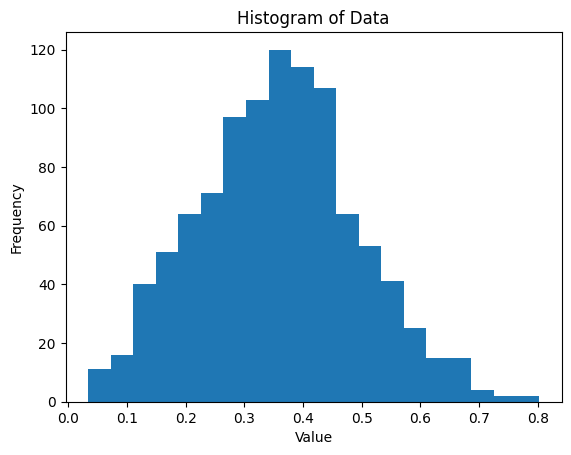

In [ ]:
plt.hist(score_similar, bins=20)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.show()

#### 6.2 Cosine similarity examples (6 marks)

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

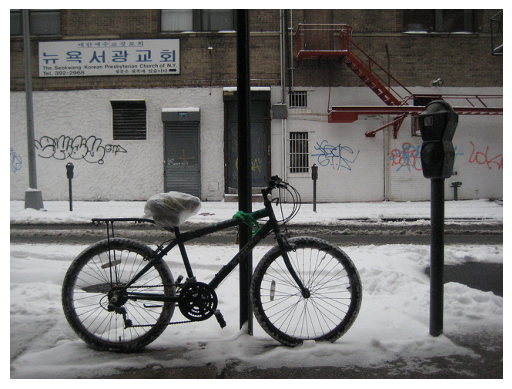

Generated caption:
a bike parked on the side of a road with a clock on it
Reference captions:
a bike locked to a pole in the snow 
a bike sitting against a pole in the snow 
a bike chained to a pole on a snowy street
a bicycle chained to a pole on a snowy day
a bike is tethered to a pole in the snow 
--------------------------------------------------
highest score: 0.844905


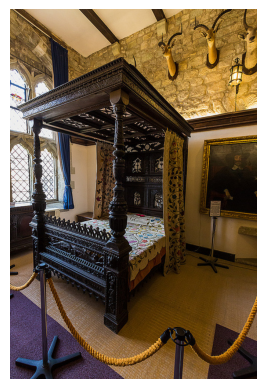

Generated caption:
a <unk> and white room with a <unk> <unk> piano
Reference captions:
an antique bed is seen in a museum 
an ornate canopy bed in a stone walled room on display
tall carved wooden bed roped off in a room
a bed room with a bed with a canopy
a bed that has a very elaborate wooden frame on it 
--------------------------------------------------
lowest score: 0.023742


In [ ]:
def get_cos_image(i):
    # Get image and captions
    image, caption, _ = dataset_test[i]
    reference_captions = test_file[test_file['image_id'] == dataset_test.df.iloc[i]['image_id']]['clean_caption']

    generated_caption = decoder.sample(image)
    generated_caption = generated_caption.flatten()  # Flatten the tensor
    generated_caption = decode_caption(generated_caption, vocab)

    img = Image.open(IMAGE_DIR+"/"+test_file['file_name'].iloc[i])
    plt.imshow(np.asarray(img))
    plt.axis('off')
    plt.show()

    print("Generated caption:")
    print(generated_caption)
    print("Reference captions:")
    for caption in reference_captions:
        print(caption)
    print("-" * 50)


get_cos_image(high_S[0])
print("highest score: %f" %high_S[1])
get_cos_image(low_S[0])
print("lowest score: %f" %low_S[1])

## 7 Comparing BLEU and Cosine similarity [16 marks]

> 7.1 Test set distribution of scores (6 marks)

> 7.2 Analysis of individual examples (10 marks)

#### 7.1 Test set distribution of scores (6 marks)

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below).

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

***Answer：***

**Summary：**
  From the results, the calculation results of these two methods are close, which proves that use two methods to verify a model is more reliable.
  1. Runtime：Took about the same amount of time to run both methods, 4 minutes for bleu and 3 minutes for Cosine.
  2. Bleu is simpler in the usage of the method, only need to call the  bleu_score = sentence_bleu(generated_caption,reference_list) function, but Cosine similarity may be more complicated steps.
  3.Bleu is more strict in calculating scores, the low score calculated by the bleu is more in the calculation of the captions.
  4.Grammaticality&semantic similarity:BLEU is useful for evaluating the grammaticality and fluency of the generated text and has been shown to correlate well with human judgments of text quality. However, it does not directly take into account the content or semantic meaning of the text. Cosine similarity, on the other hand, can capture the semantic similarity between the image and the generated caption, but it does not explicitly evaluate the grammaticality or fluency of the text
  

**BLEU :**
BLEU is an algorithm for evaluating the quality of text which has been machine-translated from one natural

1.weaknesses: The weaknesses of BLEU is that it only measures the n-gram overlap between the predicted and reference sentences and does not consider the meaning or fluency of the sentence.

2.strengths: BLEU is a fast and simple metric that can be computed relatively quickly, making it ideal for large-scale evaluations of machine translation systems.It is quick and easy to compute,in this model use 4mins to caculate.


***Cosine similarity :***

1.weaknesses:
The cosine similarity can be sensitive to the length of the vectors, which can affect the final similarity score.

2.strengths:
  It is a simple and fast method for measuring similarity between two vectors in n-dimensional space.
  It does not depend on the magnitude of the vectors, only on their direction

In [ ]:
# TO rescale the Cosine similarity scores [-1 to 1]
avg_cos = np.mean(cos_similarities)
avg_cos = (avg_cos+1)/2
print("Average Cosine similarity:", avg_cos)

Average Cosine similarity: 0.6801528087109543


In [ ]:
print("Average BLEU score:", stats['bleu'].mean())

Average BLEU score: 0.699985492608161


 #### 7.2 Analysis of individual examples (10 marks)

Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

Here's an example which both methods give similar scores :

<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


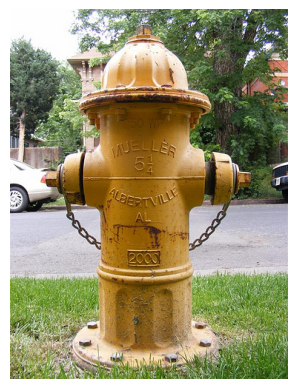

BLEU: 0.802283
cos similarity: 0.802200
Generated caption:
a yellow fire hydrant sitting next to a tree
Reference captions:
the yellow fire hydrant has a chain across it 
a yellow fire hydrant with a street in the background 
a yellow fire hydrant sits in the grass next to the street
the yellow fire hydrant is on the side of the road 
a fire hydrant is painted yellow and stands beside a street 
--------------------------------------------------


In [ ]:
# Loop over images and display them along with generated and reference captions
for i in indices:
    image, _, _ = dataset_test[i]
    reference_captions = test_file[test_file['image_id'] == dataset_test.df.iloc[i]['image_id']]['clean_caption']
    # Generate caption
    generated_caption = decoder.sample(image)
    generated_caption = generated_caption.flatten()  # Flatten the tensor
    generated_caption = decode_caption(generated_caption, vocab)
    # cos
    cos_similarities = []
    sentence1_vec = []
    for word in generated_caption.split():
      if word in vocab.word2idx:
        sentence1_vec.append(vocab.word2idx[word])
      else:
        sentence1_vec.append(vocab.word2idx['<unk>'])

    v1 = np.pad(sentence1_vec, (0, MAX_SEQ_LEN - len(sentence1_vec)), mode='constant', constant_values=0)
    v1 = np.array(v1)

    # calculate different references
    for cap in reference_captions:
      sentence2_vec = []
      for word in cap.split():
        if word in vocab.word2idx:
          sentence2_vec.append(vocab.word2idx[word])
        else:
          sentence2_vec.append(vocab.word2idx['<unk>'])

      v2 = np.pad(sentence2_vec, (0, MAX_SEQ_LEN - len(sentence2_vec)), mode='constant', constant_values=0)
      v2 = np.array(v2)

      # calculate similarity
      cos_sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
      cos_similarities.append(cos_sim)

    avg_cos = np.mean(cos_similarities)

    img = Image.open(IMAGE_DIR+"/"+test_file['file_name'].iloc[i])
    plt.imshow(np.asarray(img))
    plt.axis('off')
    plt.show()
    print("BLEU: %f" %bleu[num])
    print("cos similarity: %f" %avg_cos)
    print("Generated caption:")
    print(generated_caption)
    print("Reference captions:")
    for caption in reference_captions:
        print(caption)
    print("-" * 50)
    num += 1

Here's an example which both methods not give similar scores :

<ipython-input-24-8be9b91255e8>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feature = torch.tensor(self.features[img_id]).unsqueeze(0)


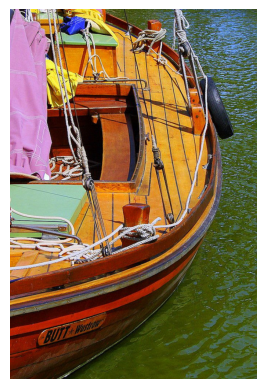

BLEU:0.393315
cos similarity: 0.356933
Generated caption:
a large white and black cat sitting on top of a wooden table
Reference captions:
a large colorful boat floating on murky water 
a close up of the end of a boat
a large yellow and brown boat floating on a body of water 
this is a colorful boat in the green water
the side of a sail boat in a lake 
--------------------------------------------------


In [ ]:
# Loop over images and display them along with generated and reference captions
for i in indices:
    # Get image and captions
    image, _, _ = dataset_test[i]
    # image = image.to(device).unsqueeze(0)
    reference_captions = test_file[test_file['image_id'] == dataset_test.df.iloc[i]['image_id']]['clean_caption']

    # Generate caption
    generated_caption = decoder.sample(image)
    generated_caption = generated_caption.flatten()  # Flatten the tensor
    generated_caption = decode_caption(generated_caption, vocab)

    # cos
    cos_similarities = []
    sentence1_vec = []
    for word in generated_caption.split():
      if word in vocab.word2idx:
        sentence1_vec.append(vocab.word2idx[word])
      else:
        sentence1_vec.append(vocab.word2idx['<unk>'])

    v1 = np.pad(sentence1_vec, (0, MAX_SEQ_LEN - len(sentence1_vec)), mode='constant', constant_values=0)
    v1 = np.array(v1)

    # calculate different references
    for cap in reference_captions:
      sentence2_vec = []
      for word in cap.split():
        if word in vocab.word2idx:
          sentence2_vec.append(vocab.word2idx[word])
        else:
          sentence2_vec.append(vocab.word2idx['<unk>'])


      v2 = np.pad(sentence2_vec, (0, MAX_SEQ_LEN - len(sentence2_vec)), mode='constant', constant_values=0)
      v2 = np.array(v2)

      # calculate similarity
      cos_sim = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
      cos_similarities.append(cos_sim)

    avg_cos = np.mean(cos_similarities)

    img = Image.open(IMAGE_DIR+"/"+test_file['file_name'].iloc[i])
    plt.imshow(np.asarray(img))
    plt.axis('off')
    plt.show()
    print("BLEU: %f" %bleu[num])
    print("cos similarity: %f" %avg_cos)
    print("Generated caption:")
    print(generated_caption)
    print("Reference captions:")
    for caption in reference_captions:
        print(caption)
    print("-" * 50)
    num += 1

BLEU and cosine similarity can give different scores when used to evaluate captions with pictures. This is because they are fundamentally different metrics that measure different aspects of caption quality.It is possible to get different scores using these metrics, as they are evaluating different aspects of caption quality.

In the first example, because there are many repeated words in the reference captions and the predicted captions has good fluency and semantics. So the scores are close. But in the second example, although the caption is fluent, the semantic gap is larger, so the bleu score prediction is better.


In some cases, the scores may be similar if the generated text is both grammatically correct and semantically relevant to the image. In other cases, they may differ if the generated text is grammatically correct but semantically unrelated to the image, or if the generated text is semantically relevant but grammatically incorrect.Judging from the degree of prediction in the two examples, the cosine prediction is more representative and more accurate. After all, semantics is more important than fluency.







